# imports

In [1]:
# %load_ext autoreload
# %autoreload 2
import pandas as pd
import numpy as np
from functools import wraps
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from matplotlib.colors import TABLEAU_COLORS, CSS4_COLORS, to_rgb
from tqdm.auto import tqdm
import seaborn as sns
from datetime import datetime, timedelta
import math
import pickle
import warnings
from scipy.signal import find_peaks, savgol_filter
from scipy.stats import mode, permutation_test, pearsonr, ttest_ind, ttest_1samp, wilcoxon, sem
from scipy.spatial import distance
from scipy import ndimage, interpolate
from pathlib import Path
import functools
import cv2
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['axes.grid'] = False
mpl.rcParams['xtick.bottom'] = True
mpl.rcParams['ytick.left'] = True
mpl.rcParams["font.family"] = "Helvetica"
mpl.rc('axes',edgecolor='black')
import os
if Path('.').resolve().name != 'Arena':
    os.chdir('../Arena')
import config
from db_models import ORM, Experiment, Strike, Block, Video, Trial
from calibration import CharucoEstimator
from analysis.pose_utils import plot_regression, colorline, pixels2cm, fit_circle, put_text
from analysis.pose import DLCArenaPose, SpatialAnalyzer
from analysis.predictors.tongue_out import TongueOutAnalyzer, TONGUE_CLASS
from analysis.strikes.strikes import Loader, StrikeAnalyzer

In [2]:
orm = ORM()
FIGURE_PATH = '/media/sil2/Data/regev/Papers/PreyTouch/'
HOME_PATH = Path(config.__file__).parent.parent
BAD_ANIMALS = ['PV03', 'PV26', 'PV72', 'PV87', 'PV88', 'PV90', 'PV101', 'PV119', 'PV144']
SCREEN_Y_POS = {'reptilearn4': -4.3, 'msi-regev': 0.06}
COLORS = {
    'PV42': '#1f77b4',
    'PV43': '#17becf',
    'PV85': '#ff7f0e',
    'PV91': '#2ca02c',
    'PV80': '#d62728',
    'PV95': '#bcbd22',
    'PV97': '#9467bd',
    'PV88': '#8c564b',
    'PV99': '#e377c2',
    'PV148': '#90EE90',
    'PV163': '#7f7f7f',
}
SCREEN_PIX_CM = {'reptilearn4': 52.704/1920, 'msi-regev': 34.3/1920}
SCREEN_START_X = {'reptilearn4': 5.59, 'msi-regev': 3.2}

# Figure 2 - Bug Application

In [3]:
ANIMALS = ['PV91', 'PV163', 'PV80', 'PV42', 'PV99']

def load_strikes_df():
  with orm.session() as s:
      orm_res = s.query(Strike, Trial, Block, Experiment).join(
        Trial, Trial.id == Strike.trial_id).join(
        Block, Block.id == Strike.block_id).join(
        Experiment, Experiment.id == Block.experiment_id).filter(
          Experiment.arena.in_(['reptilearn4', 'msi-regev']),
          Experiment.animal_id.in_(ANIMALS + ['PV95', 'PV148', 'PV97']),
          Experiment.start_time > '2023-04-18'
      ).all()
      
  df_ = []
  for strk, tr, blk, exp in orm_res:
    if tr.bug_trajectory:
      bug_traj = pd.DataFrame(tr.bug_trajectory)
      bug_x = bug_traj.x.dropna()
      exit_hole = 'right' if np.sign(bug_x.iloc[10] - bug_x.iloc[0]) == 1 else 'left'
    else:
       exit_hole = None
    miss_distance = np.sqrt((strk.x - strk.bug_x)**2 + (strk.y - strk.bug_y)**2) * SCREEN_PIX_CM[exp.arena]
    df_.append({'animal_id': exp.animal_id, 'movement_type': blk.movement_type, 'time': strk.time, 'bug_speed': strk.calc_speed, 
                'bug_type': strk.bug_type, 'bug_size': strk.bug_size, 'strike_id': strk.id, 'exit_hole': exit_hole,
                'strike_x': strk.x, 'strike_y': strk.y, 'arena': exp.arena, 'trial_id': tr.id,
                'proj_strike': strk.projected_strike_coords, 'is_hit': strk.is_hit, 'miss_distance': miss_distance, 
                'proj_bug_x': strk.projected_leap_coords and strk.projected_leap_coords[0]})
    
  df_ = pd.DataFrame(df_)
  df_['day'] = df_.time.dt.floor('d').copy()
  df_['proj_strike_x'] = df_.proj_strike.map(lambda x: x[0] if x and len(x)==2 else None)
  df_['proj_strike_y'] = df_.proj_strike.map(lambda x: x[1] if x and len(x)==2 else None)
  return df_


strk_df = load_strikes_df()

### Hits on cockroach example

is_hit=0 : 377
is_hit=1 : 144


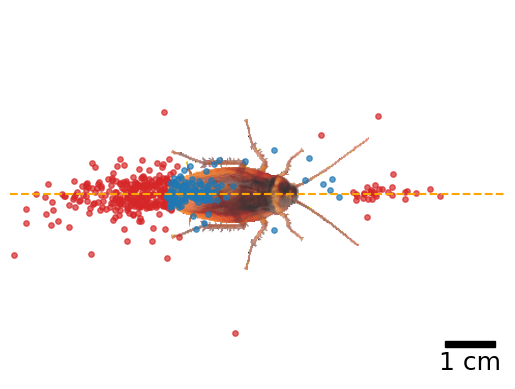

In [63]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=18)

max_proj_x, max_proj_y = 180 * SCREEN_PIX_CM['reptilearn4'], 210 * SCREEN_PIX_CM['reptilearn4']

def plot_projected(ax, af):
    ax.axhline(0, linestyle='--', color='orange')
    for state, color in {0: 'tab:red', 1: 'tab:blue'}.items():
      af_ = af.query(f'is_hit=={state}')
      print(f'is_hit={state} : {len(af_)}')
      ax.scatter(af_.proj_strike_x * SCREEN_PIX_CM['reptilearn4'], af_.proj_strike_y * SCREEN_PIX_CM['reptilearn4'], c=color, label='hit' if state else 'miss', s=15, alpha=0.7)
    ax.set_xlim([-max_proj_x, max_proj_x])
    ax.set_ylim([-max_proj_y, max_proj_y])
    
    im = cv2.imread((HOME_PATH / 'pogona_hunter/src/assets/cockroach1.png').as_posix(), -1)
    im = ndimage.rotate(im, 270)
    im[np.where(im[:, :, 3] == 0)] = (255, 255, 255, 255)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    # cax = ax.inset_axes([0.33, 0.4, 0.29, 0.2], zorder=-1)
    cax = ax.inset_axes(np.array([-70, -130, 150, 260])* SCREEN_PIX_CM['reptilearn4'], zorder=-1, transform=ax.transData)
    cax.imshow(im, aspect='auto', alpha=0.8)
    cax.axis('off')
    ax.axis('off')
    
    scalebar = AnchoredSizeBar(ax.transData,
                               1, '1 cm', 'lower right', 
                               pad=0.1,
                               color='k',
                               frameon=False,
                               size_vertical=0.2,
                               fontproperties=fontprops)

    ax.add_artist(scalebar)
    
fig, ax = plt.subplots(1, 1)
plot_projected(ax, strk_df.query('animal_id=="PV91" and bug_type=="cockroach"'))
fig.savefig(f'{FIGURE_PATH}/Figure2/cockroach_with_hits.pdf', dpi=250)

/tmp/ipykernel_135650/4221907210.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=xf, x='proj_strike_x', y='animal_id', palette=COLORS, legend=False)


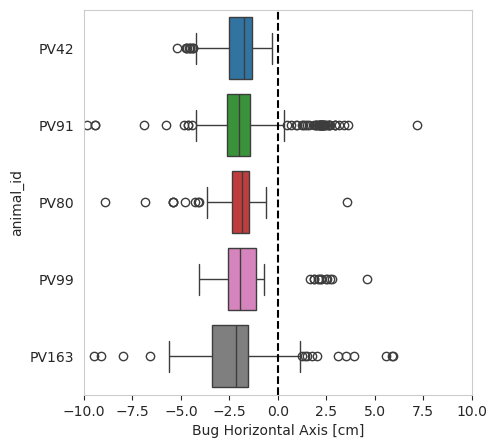

In [79]:
def plot_strikes_box():
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
  xf = strk_df.query(f'animal_id in {ANIMALS} and bug_type=="cockroach"').copy()
  def foo(row):
      arena = 'msi-regev' if row.animal_id in ['PV80','PV85','PV42'] else 'reptilearn4'
      return row.proj_strike_x * SCREEN_PIX_CM[arena]
  xf['proj_strike_x'] = xf.apply(foo, axis=1)
  sns.boxplot(data=xf, x='proj_strike_x', y='animal_id', palette=COLORS, legend=False)
  plt.xlim([-10, 10])
  plt.axvline(0, linestyle='--', color='k')
  plt.xlabel('Bug Horizontal Axis [cm]')
  fig.savefig(f'{FIGURE_PATH}/Figure2/cockroach_x_boxplot.pdf', dpi=250)
  
plot_strikes_box()

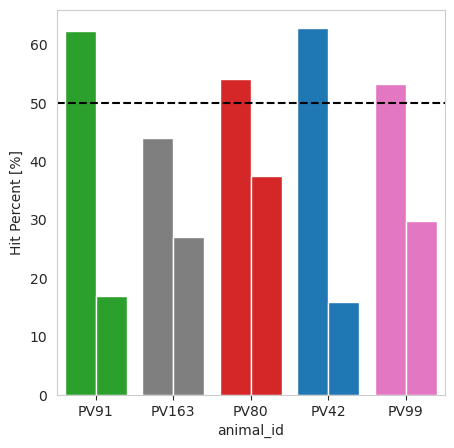

In [143]:
def hit_percent():
  x,y = 'animal_id', 'is_hit'
  
  df1 = strk_df.query(f'animal_id in {ANIMALS} and movement_type in ["random_low_horizontal","circle"]').groupby([x, 'movement_type'])[y].value_counts(normalize=True)
  df1 = df1.mul(100)
  df1 = df1.rename('percent').reset_index()
  df1['color'] = df1.apply(lambda row: COLORS[row.animal_id], axis=1)
  
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
  sns.barplot(data=df1.query('is_hit'), x=x, y='percent',hue='movement_type', ax=ax, order=ANIMALS, hue_order=["random_low_horizontal","circle"], legend=False)  # {False: 'grey', True: 'black'}
  ax.set_ylabel('Hit Percent [%]')
  ax.axhline(50, linestyle='--', color='k')
  for bar_group, desaturate_value in zip(ax.containers, [1, 1]):
      for bar, color in zip(bar_group, [COLORS[a] for a in ANIMALS]):
          bar.set_facecolor(sns.desaturate(color, desaturate_value))
  
  fig.savefig(f'{FIGURE_PATH}/Figure2/hit_percent.pdf', dpi=250)
  
hit_percent()

In [109]:
ax.containers

[<BarContainer object of 5 artists>, <BarContainer object of 5 artists>]

[49 44 56 44 40 24 19  2  0  2  0  0  0  0  2  7]
[-3.04830592 -2.66192401 -2.2755421  -1.88916019 -1.50277828 -1.11639637
 -0.73001446 -0.34363255  0.04274936  0.42913127  0.81551318  1.2018951
  1.58827701  1.97465892  2.36104083  2.74742274  3.13380465]
PV91: 285.85 +- 52.70
PV163: 280.34 +- 41.04
PV80: 265.13 +- 91.08
PV42: 251.16 +- 63.17
PV99: 273.71 +- 37.79
all: 269.96 +- 60.38


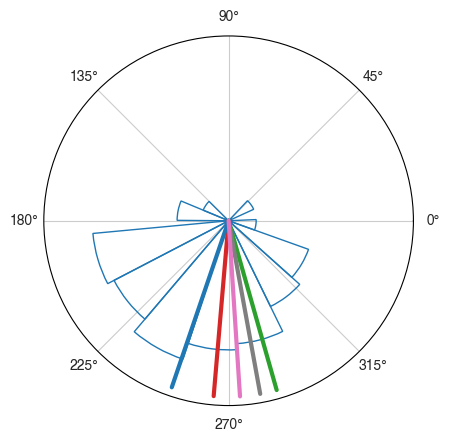

In [23]:
def circular_hist(ax, x, bins=16, density=True, offset=0, gaps=True, color='C0'):
    """
    Produce a circular histogram of angles on ax.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    # Wrap angles to [-pi, pi)
    x = (x+np.pi) % (2*np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        bins = np.linspace(-np.pi, np.pi, num=bins+1)

    # Bin data and record counts
    n, bins = np.histogram(x, bins=bins)
    print(n)
    print(bins)

    # Compute width of each bin
    widths = np.diff(bins)

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area/np.pi) ** .5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n

    # Plot data on ax
    patches = ax.bar(bins[:-1], radius, zorder=1, align='edge', width=widths,
                     edgecolor=color, fill=False, linewidth=1)

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

    return n, bins, patches


def polar_circle_trials_plot(example_animal='PV42'):
  # Visualise by area of bins
  xf = strk_df.query('movement_type=="circle"').copy()
  xf['strike_x'] = xf.strike_x - 960
  xf['strike_y'] = xf.strike_y - 358.5
  xf['azimuth'] = np.arctan2(xf.strike_y, xf.strike_x) + np.pi
  xf['azimuth'] = (xf['azimuth']+np.pi) % (2*np.pi) - np.pi
  angs = xf.query(f'animal_id=="{example_animal}"')['azimuth'].values

  # angs[angs>2*np.pi] = angs[angs>2*np.pi] - 2*np.pi
  
  fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection='polar'))
  n, bins, patches = circular_hist(ax, angs, color=COLORS[example_animal])
  
  for animal_id in ANIMALS + ['all']:
    xf_ = xf.query(f'movement_type=="circle"')
    if animal_id != 'all':
      xf_ = xf_.query(f'animal_id=="{animal_id}"')
    else:
      xf_ = xf_.query(f'animal_id in {ANIMALS}')
    m = np.arctan2(xf_.strike_y.mean(), xf_.strike_x.mean()) + np.pi
    m = (m+np.pi) % (2*np.pi) - np.pi
    print(f'{animal_id}: {np.rad2deg(2*np.pi+m):.2f} +- {np.rad2deg(xf_.azimuth.std()):.2f}')
    
    if animal_id != 'all':
      ax.plot([m, m], [0, 0.3], color=COLORS[animal_id], label=animal_id, linewidth=3)
  fig.savefig(f'{FIGURE_PATH}/Figure2/circle_polar.pdf', dpi=250)


polar_circle_trials_plot('PV42')

### Miss Distance

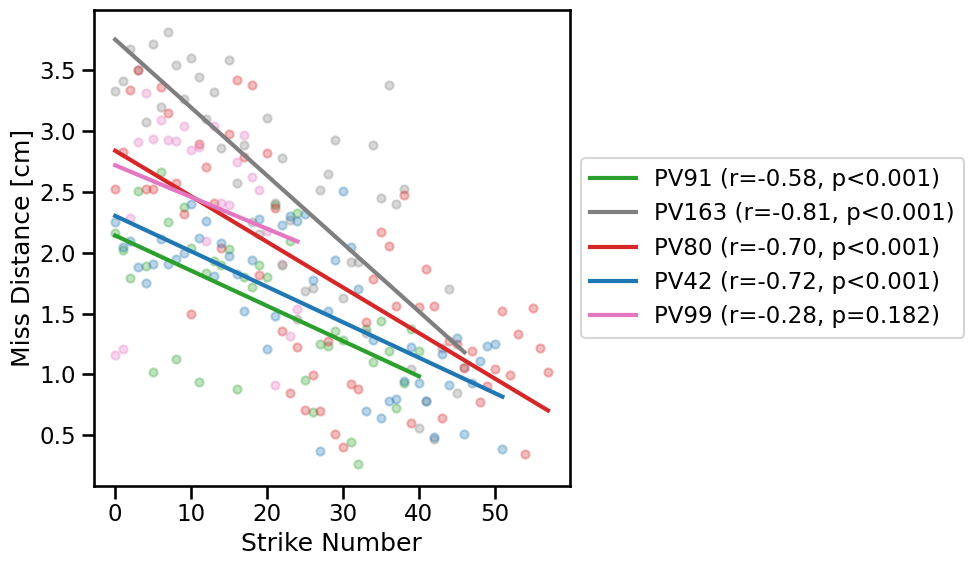

In [128]:
%matplotlib inline

with sns.plotting_context("talk"):
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    for i, animal_id in enumerate(ANIMALS):
        # g2 = strk_df.query(f'animal_id=="{animal_id}" and movement_type=="random_low_horizontal" and bug_type!="worm" and miss_distance<125').sort_values(by='time')
        g2 = strk_df.query(f'animal_id=="{animal_id}" and movement_type=="circle" and bug_type!="worm" \
                             and miss_distance<4 and bug_speed<9').sort_values(by='time')
        if g2.empty:
            continue
        g2 = g2.groupby((g2.time-g2.time.iloc[0]).dt.total_seconds()//0.1).first()
        if len(g2) > 100:
            g2 = g2.query('bug_speed < 7')
        x = np.arange(len(g2))
        res = g2.miss_distance.values
        # if animal_id == EXAMPLE_ANIMAL:
        sc = ax.scatter(x, res, color=COLORS[animal_id], alpha=0.3, s=35)
        plot_regression(ax, x, res, color=COLORS[animal_id], prefix=animal_id, linewidth=3)
        ax.set_ylabel('Miss Distance [cm]')
        ax.set_xlabel('Strike Number')
        ax.tick_params(bottom=True, left=True)
        ax.set_box_aspect(1)

    fig.tight_layout()
    fig.savefig(f'{FIGURE_PATH}/Figure2/miss_distance.pdf', dpi=250)

### Miss Distance per Trial (supplementary Figure)

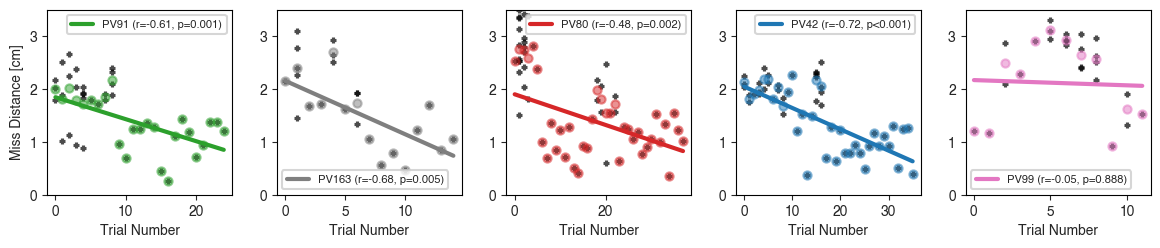

In [45]:
%matplotlib inline

fig, axes = plt.subplots(1, len(ANIMALS), figsize=(12, 4))
with sns.plotting_context("talk"):
    for i, animal_id in enumerate(ANIMALS):
        g2 = strk_df.query(f'animal_id=="{animal_id}" and movement_type=="circle" and bug_type!="worm" \
                             and miss_distance<4 and bug_speed<9').sort_values(by='time')
        if g2.empty:
            continue
        g2 = g2.groupby((g2.time-g2.time.iloc[0]).dt.total_seconds()//0.1).first()
        if len(g2) > 40 and animal_id not in ["PV80", "PV99"]:
            g2 = g2.query('bug_speed < 7')
        
        g2_ = g2.groupby('trial_id').mean()
        trial_map = {trial_id: k for k, trial_id in enumerate(g2_.index)}
        g2['trial_number'] = g2.trial_id.map(trial_map)
        
        res = g2_.miss_distance.values
        x = np.arange(len(g2_))
        
        ax = axes[i]
        ax.scatter(g2.trial_number, g2.miss_distance, marker='+', color='k', alpha=0.7, s=25)
        sc = ax.scatter(x, res, color=COLORS[animal_id], alpha=0.5, s=35)
        plot_regression(ax, x, res, color=COLORS[animal_id], prefix=animal_id, linewidth=3, is_legend=True, is_legend_outside=False, legend_fontsize=8)
        
        if i == 0:
          ax.set_ylabel('Miss Distance [cm]')
        ax.set_xlabel('Trial Number')
        ax.set_ylim([0, 3.5])
        ax.tick_params(bottom=True, left=True)
        ax.set_box_aspect(1)

    fig.tight_layout()
    fig.savefig(f'{FIGURE_PATH}/Figure2/miss_distance_trial_number.pdf', dpi=300, bbox_inches="tight")

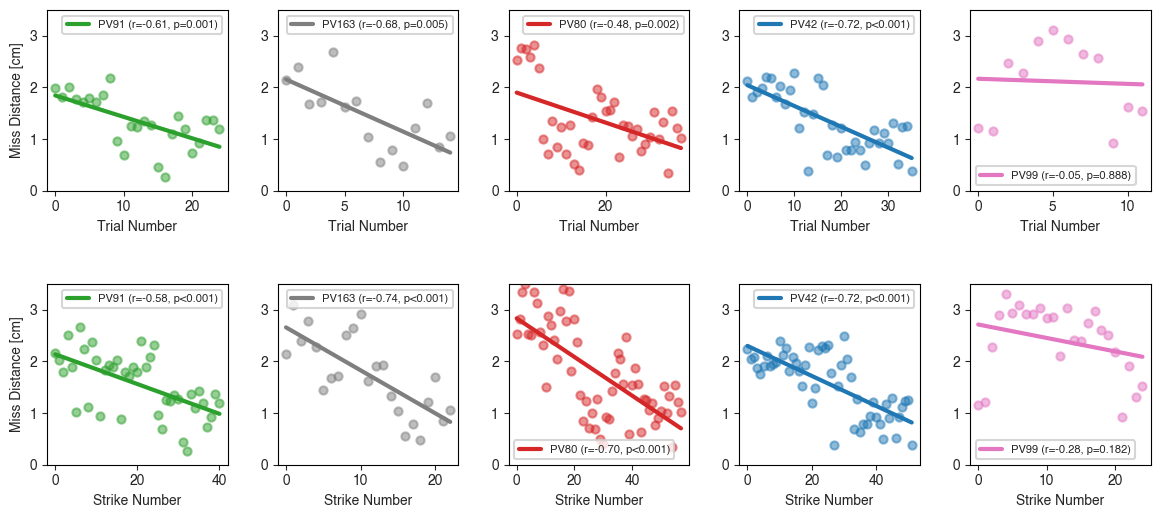

In [47]:
%matplotlib inline

fig, axes = plt.subplots(2, len(ANIMALS), figsize=(12, 6))
with sns.plotting_context("talk"):
    for i, animal_id in enumerate(ANIMALS):
        g2 = strk_df.query(f'animal_id=="{animal_id}" and movement_type=="circle" and bug_type!="worm" \
                             and miss_distance<4 and bug_speed<9').sort_values(by='time')
        if g2.empty:
            continue
        g2 = g2.groupby((g2.time-g2.time.iloc[0]).dt.total_seconds()//0.1).first()
        if len(g2) > 40 and animal_id not in ["PV80", "PV99"]:
            g2 = g2.query('bug_speed < 7')
        
        for ax, g2_, xlabel in zip(axes[:, i], [g2.groupby('trial_id').mean(), g2], ['Trial Number', 'Strike Number']):
          res = g2_.miss_distance.values
          x = np.arange(len(g2_))
          sc = ax.scatter(x, res, color=COLORS[animal_id], alpha=0.5, s=35)
          plot_regression(ax, x, res, color=COLORS[animal_id], prefix=animal_id, linewidth=3, is_legend=True, is_legend_outside=False, legend_fontsize=8)
          
          if i == 0:
            ax.set_ylabel('Miss Distance [cm]')
          ax.set_xlabel(xlabel)
          ax.set_ylim([0, 3.5])
          ax.tick_params(bottom=True, left=True)
          ax.set_box_aspect(1)

    fig.tight_layout()
    fig.savefig(f'{FIGURE_PATH}/Figure2/miss_distance_trial_and_strike_number.pdf', dpi=300, bbox_inches="tight")

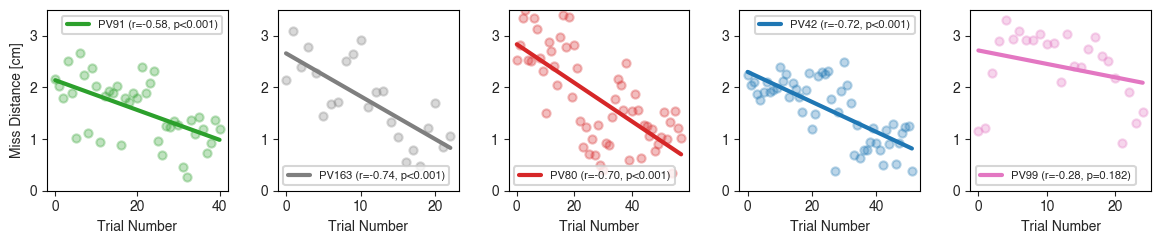

In [24]:
%matplotlib inline

fig, axes = plt.subplots(1, len(ANIMALS), figsize=(12, 4))
with sns.plotting_context("talk"):
    for i, animal_id in enumerate(ANIMALS):
        g2 = strk_df.query(f'animal_id=="{animal_id}" and movement_type=="circle" and bug_type!="worm" \
                             and miss_distance<4 and bug_speed<9').sort_values(by='time')
        if g2.empty:
            continue
        g2 = g2.groupby((g2.time-g2.time.iloc[0]).dt.total_seconds()//0.1).first()
        if len(g2) > 40 and animal_id not in ["PV80", "PV99"]:
            g2 = g2.query('bug_speed < 7')
        # g2 = g2.groupby('trial_id').mean()
        x = np.arange(len(g2))
        res = g2.miss_distance.values
        # if animal_id == EXAMPLE_ANIMAL:
        ax = axes[i]
        sc = ax.scatter(x, res, color=COLORS[animal_id], alpha=0.3, s=35)
        plot_regression(ax, x, res, color=COLORS[animal_id], prefix=animal_id, linewidth=3, is_legend=True, is_legend_outside=False, legend_fontsize=8)
        if i == 0:
          ax.set_ylabel('Miss Distance [cm]')
        ax.set_xlabel('Trial Number')
        ax.set_ylim([0, 3.5])
        ax.tick_params(bottom=True, left=True)
        ax.set_box_aspect(1)

    fig.tight_layout()
    fig.savefig(f'{FIGURE_PATH}/Figure2/miss_distance_trial_number.pdf', dpi=250, bbox_inches="tight")

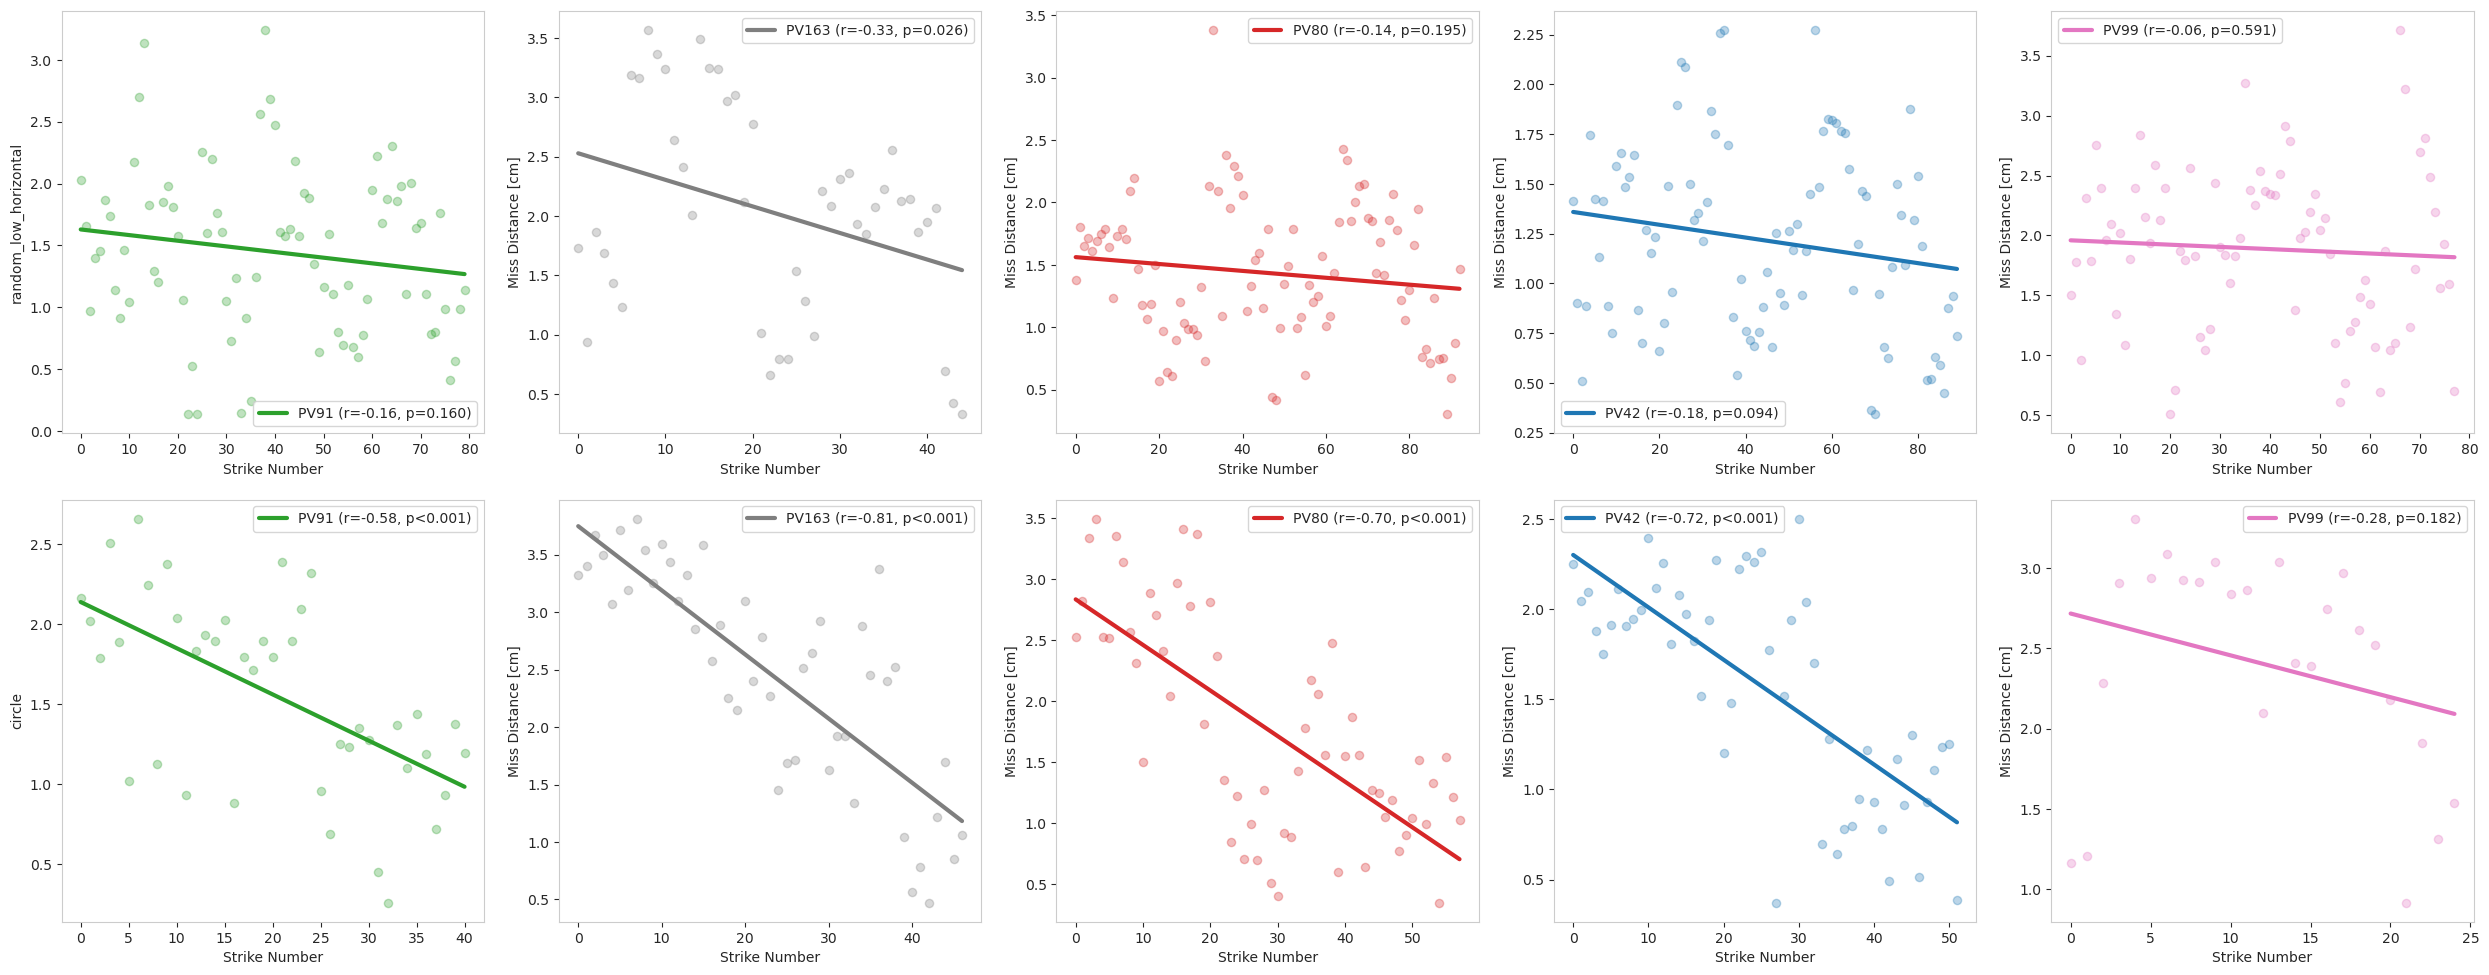

In [202]:
%matplotlib inline

fig, axes = plt.subplots(2, len(ANIMALS), figsize=(25, 10))
for j, animal_id in enumerate(ANIMALS):
    for i, mt in enumerate(['random_low_horizontal', 'circle']):
        # g2 = strk_df.query(f'animal_id=="{animal_id}" and movement_type=="random_low_horizontal" and bug_type!="worm" and miss_distance<125').sort_values(by='time')
        g2 = strk_df.query(f'animal_id=="{animal_id}" and movement_type=="{mt}" and bug_type!="worm" \
                                and miss_distance<4 and bug_speed<9').sort_values(by='time')
        if g2.empty:
            continue
        g2 = g2.groupby((g2.time-g2.time.iloc[0]).dt.total_seconds()//0.1).first()
        if len(g2) > 100:
            g2 = g2.query('bug_speed < 7')
        x = np.arange(len(g2))
        res = g2.miss_distance.values
        # if animal_id == EXAMPLE_ANIMAL:
        ax = axes[i, j]
        sc = ax.scatter(x, res, color=COLORS[animal_id], alpha=0.3, s=35)
        plot_regression(ax, x, res, color=COLORS[animal_id], prefix=animal_id, linewidth=3, is_legend_outside=False)
        ax.set_ylabel('Miss Distance [cm]')
        ax.set_xlabel('Strike Number')
        ax.tick_params(bottom=True, left=True)
        ax.set_box_aspect(1)
        if j == 0:
            ax.set_ylabel(mt)

fig.tight_layout()

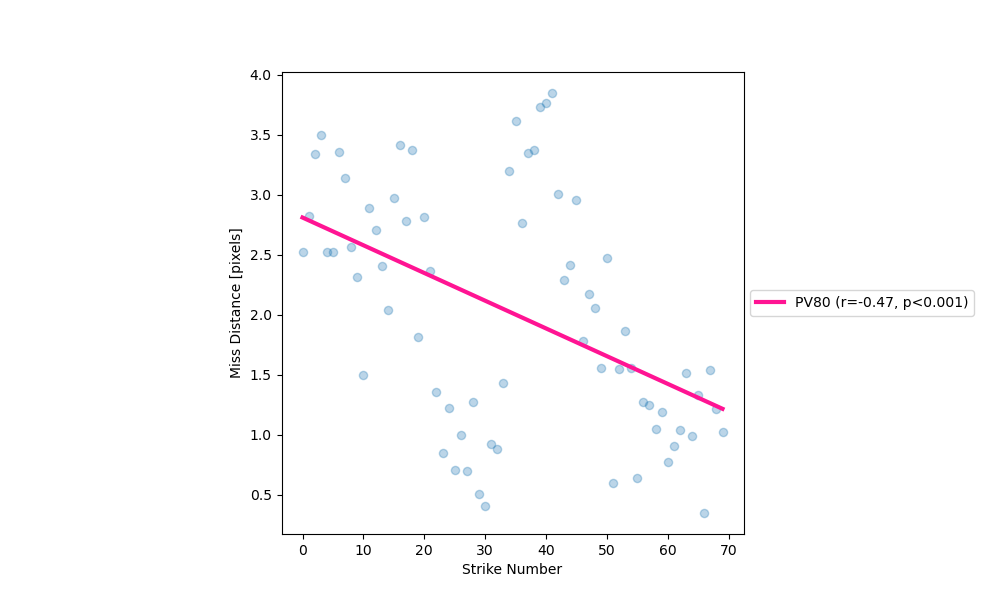

In [119]:
%matplotlib widget
animal_id = 'PV80'

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
g2 = strk_df.query(f'animal_id=="{animal_id}" and movement_type=="circle" and bug_type!="worm" and miss_distance<4').sort_values(by='time')
# g2 = g2.groupby((g2.time-g2.time.iloc[0]).dt.total_seconds()//0.1).first()
x = np.arange(len(g2))
res = g2.miss_distance.values
sc = ax.scatter(x, res, alpha=0.3, s=35)
plot_regression(ax, x, res, prefix=animal_id, linewidth=3)
ax.set_ylabel('Miss Distance [pixels]')
ax.set_xlabel('Strike Number')
ax.tick_params(bottom=True, left=True)
ax.set_box_aspect(1)

annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                bbox=dict(boxstyle="round", fc="w"),
                arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

def update_annot(ind):
    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    d = [g2.iloc[i][['bug_type','exit_hole','bug_speed','is_hit', 'time']].to_string() for i in ind["ind"]]
    text = d[0]
    # text = "{}".format(" ".join(list(map(str, ind["ind"]))))
    annot.set_text(text)
    # annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
    annot.get_bbox_patch().set_alpha(0.4)
    

def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)

plt.show()

### Polar plot of bug preferences

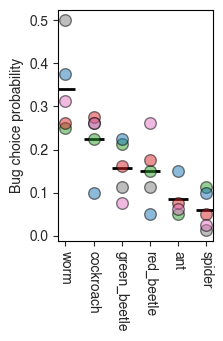

In [24]:
%matplotlib inline

animals_map = {'PV80': 'PV97', 'PV42': 'PV148', 'PV163': 'PV95'}
bugs = ['cockroach', 'worm', 'spider', 'ant', 'red_beetle', 'green_beetle']
bugs = bugs + [bugs[0]]
angles = np.linspace(0, 2*np.pi, len(bugs))
# fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
fig, ax = plt.subplots(figsize=(2, 3))
n_samples = 80
bugs_df = []
for animal_id in ANIMALS:
  animal_id_ = animals_map.get(animal_id, animal_id)
  vc = strk_df.query(f'animal_id=="{animal_id_}"').sample(n_samples, random_state=42).bug_type.value_counts(normalize=True).to_dict()
  for bug_type, val in vc.items():
      bugs_df.append({'bug_type': bug_type, 'val': val, 'animal_id': animal_id})
  # vals = [vc.get(bug, 0) for bug in bugs]
  # ax.plot(angles, vals, color=COLORS[animal_id])

bugs_df = pd.DataFrame(bugs_df)
avg = bugs_df.groupby('bug_type').val.mean().sort_values(ascending=False)
ax.scatter(avg.index, avg.values, linewidth=2, color='black', label='Average', marker='_', s=200)
for animal_id in bugs_df.animal_id.unique():
  ax.scatter(avg.index, bugs_df.query(f'animal_id=="{animal_id}"').set_index('bug_type').val.reindex(avg.index), color=COLORS[animal_id], 
             label=animal_id, alpha=0.5, s=70, edgecolors='black')

# sns.barplot(x='bug_type', y='val', hue='animal_id', data=bugs_df,  palette=COLORS, legend=False, ax=ax)
ax.set_ylabel('Bug choice probability')
ax.tick_params(axis='x', labelrotation=270)
# ax.set_rmax(0.5)
# ax.set_rticks([0.1, 0.2, 0.3, 0.4, 0.5])  # Less radial ticks
# ax.set_xticks(angles)
# ax.set_xticklabels([b.replace('_', ' ') for b in bugs])
# plt.setp(ax.get_xticklabels(), fontsize=14, fontweight="bold")
# ax.grid(True)

fig.savefig(f'{FIGURE_PATH}/Figure2/bugs_preferences.pdf', dpi=250, bbox_inches="tight")

,bug_type,val,animal_id
5,ant,0.0500,PV91
15,ant,0.0750,PV80
19,ant,0.1500,PV42
27,ant,0.0625,PV99


# Figure 3 - Pose Estimation

### Frog vs. Lizard

In [ ]:
# add deeplabcut to frog 

from analysis.predictors.deeplabcut import DLCPose

with open(f'/data/Pogona_Pursuit/notebooks/frog_strike_frames.pkl', 'rb') as f:
    data = pickle.load(f)
    
dlc = DLCPose('front')
dlc.init(data['frames'][0][1])

anno_frames = []
for frame_id, frame in data['frames']:
    pdf_ = dlc.predict(frame)
    annotated_frame = dlc.plot_predictions(frame.copy(), 0, pdf_, parts2plot=['nose'], colors=[(189,103,148)])
    anno_frames.append((frame_id, annotated_frame))
    # plt.figure()
    # plt.imshow(annotated_frame)
    
cap = cv2.VideoCapture('/media/sil2/Data/regev/frog_strike1.avi')
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
pdf = []
for i in range(n_frames):
    ret, frame = cap.read()
    pdf.append(dlc.predict(frame))

pdf = pd.concat(pdf)

data1 = data.copy()
data1['y_values'] = pdf['nose']['cam_y'].values.tolist()
data1['frames'] = anno_frames
with open(f'/data/Pogona_Pursuit/notebooks/frog1_strike_frames.pkl', 'wb') as f:
    pickle.dump(data1, f)

In [5]:
# create lizard artifact

def create_lizard_artifact(strike_id, is_save=True):
    ld = Loader(strike_id, 'front', is_load_pose=True, is_use_db=False, sec_before=2, sec_after=2, is_dwh=True)
    sa = StrikeAnalyzer(ld)
    pf = sa.pose_df
    t = (pf.time - pf.time.iloc[0]).dt.total_seconds()
    y_values = pf['y'].values - SCREEN_Y_POS['reptilearn4']
    frames = []
    n_frames = len(y_values)
    frames2plot = [n_frames//2-30, n_frames//2-17, n_frames//2-13, n_frames//2-5, n_frames//2+1]
    
    fig, axes = plt.subplots(1, len(frames2plot), figsize=(20, 4))
    i, j = 0, 0
    for frame_id, frame in ld.gen_frames_around_strike():
        if i in frames2plot:
            frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
            cX = round(pf['cam_x'][frame_id])
            cY = round(pf['cam_y'][frame_id])
            cv2.circle(frame, (cX, cY), 8, (255, 0, 255), -1)
            frames.append((i, frame))
            axes[j].imshow(frame[470:1000, 730:1250])
            j += 1
        i += 1
    fig.tight_layout()
    
    if is_save:
        with open(f'{FIGURE_PATH}/assets/pogona2_strike_frames.pkl', 'wb') as f:
            pickle.dump({'frames': frames, 'y_values': y_values}, f)
            
create_lizard_artifact(strike_id=106, is_save=False)
# create_lizard_artifact(strike_id=2532, is_save=True)

MissingFile: unable to find frames_timestamps in /data/Pogona_Pursuit/output/experiments/PV85/20230422/block2/videos/frames_timestamps/front_20230422T100031.csv

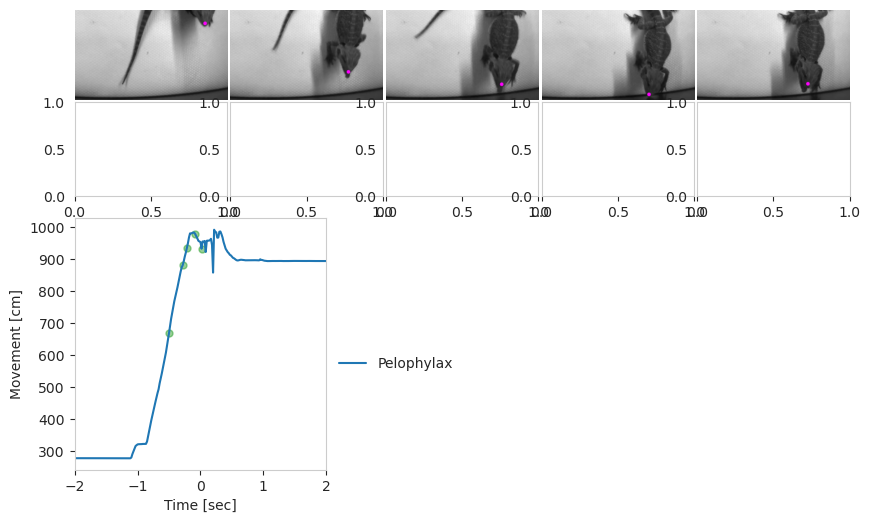

In [13]:
fig = plt.figure(figsize=(10, 6))
grid = fig.add_gridspec(ncols=1, nrows=2, height_ratios=[3, 4], hspace=0.1) 
upper_grid = grid[0, :].subgridspec(2, 5, wspace=0.02, hspace=0.001)
lower_grid = grid[1, :].subgridspec(1, 3, wspace=0.04)
upper_axes = upper_grid.subplots()
lower_axes = lower_grid.subplots()
# lower_axes[0].axis('equal')
# lower_axes[0].set_aspect('equal', adjustable='box')
for animal, frames_axes in [('pogona1', upper_axes[0, :])]:
    with open(f'{FIGURE_PATH}/assets/{animal}_strike_frames.pkl', 'rb') as f:
        data = pickle.load(f)
    
    if animal == 'frog1':
        animal = 'frog'
    frames, y_values = data['frames'], data['y_values']
    t = np.linspace(-2, 2, len(y_values))
    if animal == 'frog':
        y_values = -np.array(y_values)
        y_values = savgol_filter(y_values, 11, polyorder=0)
        y_values = 20 * (y_values - y_values.min()) / (y_values.max() - y_values.min()) - 1
        y_values = y_values.tolist()
        dy = 7
        y_values = dy * [y_values[0]] + y_values[:len(y_values)-dy]
        frames = [(i+dy, frame) for i, frame in frames]
    
    lower_axes[0].plot(t, y_values, label='Pogona' if animal == 'pogona' else 'Pelophylax')
    lower_axes[0].set_xlabel('Time [sec]')
    lower_axes[0].set_ylabel('Movement [cm]')
    lower_axes[0].scatter([t[k] for k, _ in frames], [y_values[k] for k, _ in frames], c='tab:green', s=25, alpha=0.5)
            
    for j, (_, annotated_frame) in enumerate(frames):
        frames_axes[j].imshow(annotated_frame[720:, 570:1180] if animal == 'frog' else annotated_frame[604:1000, 579:1250])
        frames_axes[j].axis('off')

lower_axes[0].legend(loc='upper left', frameon=False, bbox_to_anchor=(1, 0.5))
lower_axes[0].margins(x=0)
lower_axes[0].set_box_aspect(1)
lower_axes[0].tick_params(bottom=True, left=True)
for i in [1, 2]:
    lower_axes[i].axis('off')
fig.savefig(f'{FIGURE_PATH}/Figure3/frog_vs_lizard.pdf', dpi=250)

In [ ]:
'/data/Pogona_Pursuit/output/experiments/PV91/20230513/block1/videos/front_20230513T173027.mp4'

In [4]:
with orm.session() as s:
    strk = s.query(Strike).filter_by(id=2530).first
    # vid = s.query(Video).filter_by(id=403).first()
    # vid.path = '/media/sil2/Data/regev/experiments/reptilearn4/PV91/20230513/block1/videos/front_20230513T173027.mp4'
    # s.commit()

### trajectory example

In [5]:
ld = Loader(3333, 'front', is_debug=False, orm=orm, is_use_db=True, sec_before=4, sec_after=3.8)
af = ld.frames_df.dropna(subset=[('nose', 'cam_x')])['nose']
x = np.linspace(0, 1, len(af))
cmap = mpl.colormaps['viridis']
cmap_mat = (cmap(x)[:, :3] * 255).astype(int)
last_frame_id = af.index[-2]
_, frame = next(ld.gen_frames([last_frame_id]))
frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
for i, row in af.iloc[:-3].reset_index(drop=True).iterrows():
    color = cmap_mat[i, :].tolist()
    frame = cv2.circle(frame, (int(row.cam_x), int(row.cam_y)), 6, color, -1)

for bp in ['nose', 'left_ear', 'right_ear']:
    row = ld.frames_df[bp].loc[last_frame_id]
    if np.isnan(row.cam_x):
        continue
    frame = cv2.circle(frame, (int(row.cam_x), int(row.cam_y)), 9, (255, 0, 0), -1)

frame = frame[100:, :]
fig, ax = plt.subplots(1, 1)
ax.imshow(frame)
ax.grid(False)
ax.axis('off')
secs = (af.index.values - af.index[0]) / 60
cbaxes = ax.inset_axes([0.15, 0.9, 0.25, 0.04])
mpl.colorbar.ColorbarBase(cbaxes, cmap=cmap, norm=mpl.colors.Normalize(vmin=0, vmax=secs.max()), orientation='horizontal', label='Time from\ntrajectory start [sec]')
fig.savefig(f'{FIGURE_PATH}/Figure3/single_trajectory.pdf', dpi=250)

error: OpenCV(4.5.4-dev) /tmp/pip-req-build-6qnmwb6g/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


### Top trajectories

In [ ]:
idx = {}
dev_angs_speed, h = 1440, 1080
for p in Path(config.EXPERIMENTS_DIR).rglob('*/predictions_gd/*.csv'):
    rf = pd.read_csv(p, index_col=0)
    rf['vid_name'] = p.stem
    idx[p.stem] = rf
    
rdf = pd.concat(idx.values())
rdf['x'] = rdf.cam_x * dev_angs_speed
rdf['y'] = rdf.cam_y * h
rdf['time'] = rdf.vid_name.map(lambda x: datetime.strptime(x.split('_')[1], '%Y%m%dT%H%M%S'))

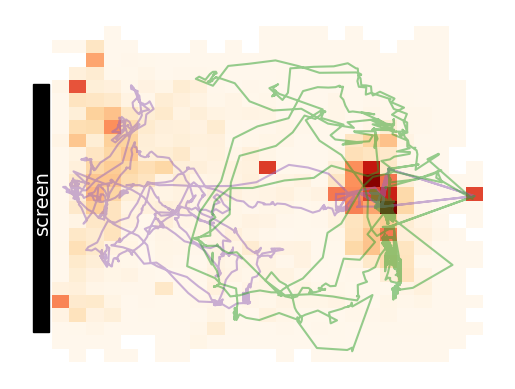

In [ ]:
# plot 
example_vids = [('top_20230625T093053', 'tab:purple'), ('top_20230624T090108', 'tab:green')]
fig, ax = plt.subplots(1,1)
max_hour = 16
rdf_ = rdf.loc[rdf.time.dt.hour <= max_hour].dropna()
# print(f'Number of sessions ')
h = sns.histplot(data=rdf_, x='x', y='y', bins=(25, 25), ax=ax, stat='probability', 
                 cmap=plt.cm.get_cmap('OrRd'),
                 cbar=False, cbar_kws=dict(shrink=.75, label='Probability'))
for vid_name, color in example_vids:
    rf = rdf.query(f'vid_name=="{vid_name}"').sort_values(by='frame_id')
    ax.plot(rf.x, rf.y, color=color, alpha=0.5)
ax.add_patch(Rectangle((0, 150), 50, 700, color='k'))
ax.text(0, (150+700)//2, 'screen', rotation=90, color='w', va='bottom', fontsize=14)
ax.axis('off')
fig.savefig(f'{FIGURE_PATH}/Figure3/arena_top_trajectories.pdf', dpi=250)

# Figure 4 - Real-time strike detection

### Tongue Dataset

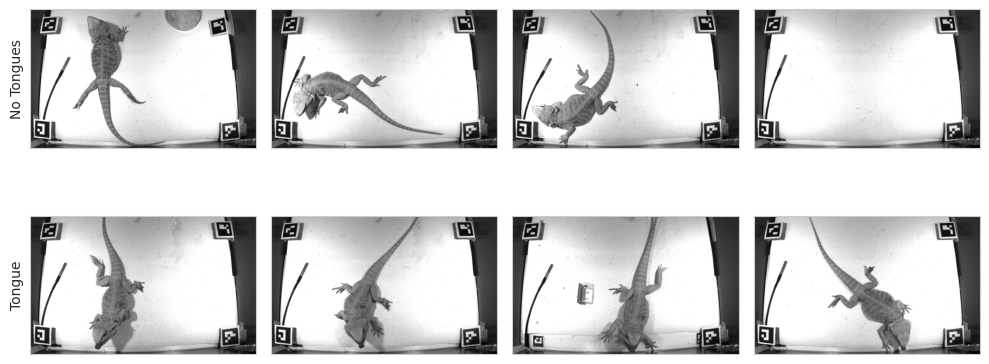

In [ ]:
data = {
    'No Tongues': [
        '/data/Pogona_Pursuit/output/datasets/pogona_tongue/dataset/no_tongues/1671363126.3047485.jpg',
        '/data/Pogona_Pursuit/output/datasets/pogona_tongue/dataset/no_tongues/1671549030.4634392.jpg',
        '/data/Pogona_Pursuit/output/datasets/pogona_tongue/dataset/no_tongues/1671551711.601417.jpg',
        '/data/Pogona_Pursuit/output/datasets/pogona_tongue/dataset/no_tongues/front_20221213T101615_17006.jpg'
    ],
    'Tongue': [
        '/data/Pogona_Pursuit/output/datasets/pogona_tongue/dataset/tongues/1671545625.2763906.jpg',
        '/data/Pogona_Pursuit/output/datasets/pogona_tongue/dataset/tongues/1671545655.1729114.jpg',
        '/data/Pogona_Pursuit/output/datasets/pogona_tongue/dataset/tongues/1671707770.8067603.jpg',
        '/data/Pogona_Pursuit/output/datasets/pogona_tongue/dataset/tongues/front_20221213T101615_14380.jpg'
    ]
}

fig, axes = plt.subplots(2, 4, figsize=(10, 5))
for i, (title, frames) in enumerate(data.items()):
    for j, p in enumerate(frames):
        frame = cv2.imread(p)
        axes[i, j].imshow(frame[400:950, 300:1200])
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        if j == 0:
            axes[i, j].set_ylabel(title)
fig.tight_layout()
fig.savefig(f'{FIGURE_PATH}/tongue_dataset.pdf', dpi=250)

### model evaluation

model analysis.predictors.tongue_out load from: /data/Pogona_Pursuit/output/models/tongue_out/20231128_162618
Loaded tongue dataset with: {'no_tongues': 5073, 'tongues': 1895}


  0%|          | 0/1045 [00:00<?, ?it/s]

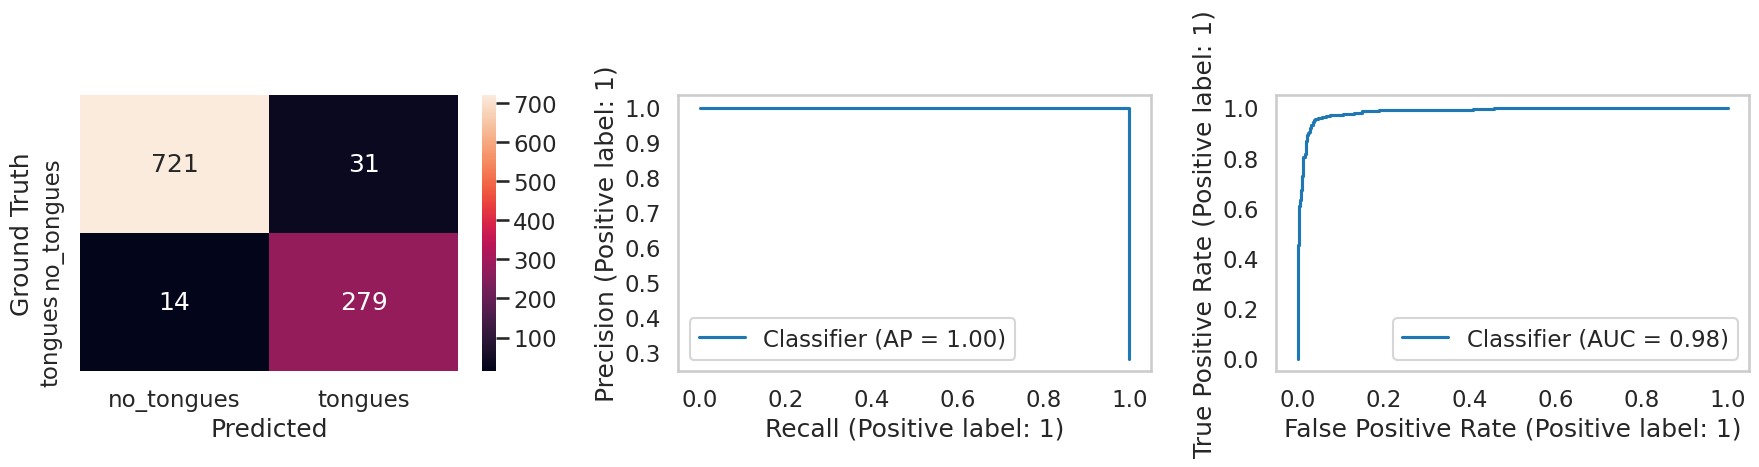

In [ ]:
%matplotlib inline
from analysis.predictors.tongue_out import TongueTrainer

tt = TongueTrainer(model_path='/data/Pogona_Pursuit/output/models/tongue_out/20231128_162618')
with sns.plotting_context("talk"):
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    tt.all_data_evaluation(axes, is_equalize_dataset=False, is_test_set=True)
    fig.tight_layout()
    fig.savefig(f'{FIGURE_PATH}/tongue_model_evaluation.pdf', dpi=250, bbox_inches="tight")

In [ ]:
from torchviz import make_dot
import torch

x = torch.randn(1, 1, 224, 224).cuda()
yhat = tt.model(x)
make_dot(yhat.mean(), params=dict(list(tt.model.named_parameters()))).render("rnn_torchviz", format="pdf")

'rnn_torchviz.pdf'

### Example jump trial

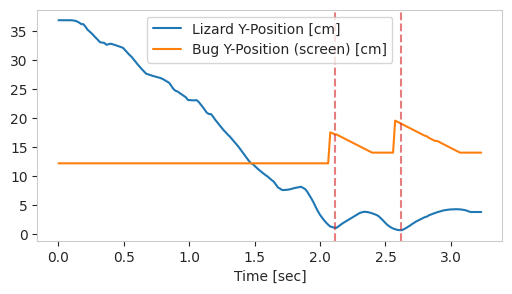

In [ ]:
def plot_jump_example(trial_id, start_id=None):
    with orm.session() as s:
        orm_res = s.query(Trial, Block).join(Block, Block.id == Trial.block_id).filter(Trial.id==trial_id).first()
        traj = pd.DataFrame(orm_res[0].bug_trajectory)
        traj['time'] = pd.to_datetime(traj.time).dt.tz_localize(None)
        vid = [vid for vid in orm_res[1].videos if vid.cam_name=='front'][0]
        pose = DLCArenaPose(cam_name='front').load(video_db_id=int(vid.id))
        pose['time'] = pd.to_datetime(pose.time, unit='s')
        pose = pd.concat([pose['time'], pose['nose']], axis=1)
        
        df = pd.merge_asof(left=traj, right=pose, left_on='time', right_on='time', 
                           direction='nearest', tolerance=pd.Timedelta('100 ms'), suffixes=('_traj', '_pose'))
    
    if start_id is not None:
        df = df.iloc[start_id:]
    df['time'] = (df.time - df.time.iloc[0]).dt.total_seconds()
    df['y_traj'] = -(df.y_traj * (53/1440)) + 40
    df['y_pose'] = df.y_pose - df.y_pose.min()
    df['y_pose'] = savgol_filter(df.y_pose.values, window_length=11, polyorder=0)
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    sns.lineplot(data=df, x='time', y='y_pose', ax=ax, label='Lizard Y-Position [cm]')
    sns.lineplot(data=df, x='time', y='y_traj', ax=ax, label='Bug Y-Position (screen) [cm]')
    peaks, _ = find_peaks(-df.y_pose, height=-2, distance=20, width=8)
    for t_ in df.time.iloc[peaks].values:
      plt.axvline(t_, linestyle='--', c='tab:red', alpha=0.6)
    # ax.set_ylim([0, 20])
    # ax.set_title(str(trial_id))
    ax.set_ylabel('')
    ax.set_xlabel('Time [sec]')
    ax.legend()
    ax.tick_params(bottom=True, left=True)
    fig.savefig(f'{FIGURE_PATH}/jump_example_{trial_id}.pdf', dpi=250, bbox_inches="tight")
    

# good trials: [5964, 1787, 2006, 1840]
plot_jump_example(5964, start_id=140)

### jump times before strikes

In [ ]:
with orm.session() as s:
    orm_res = s.query(Strike, Block, Experiment).join(
      Block, Block.id == Strike.block_id).join(
      Experiment, Experiment.id == Block.experiment_id).filter(
        Experiment.arena == 'reptilearn4',
        Experiment.start_time > '2023-06-10',
        Block.movement_type == 'jump_up'
    ).all()
    
    idx = {}
    for strk, _, _ in tqdm(orm_res):
        try:
          ld = Loader(int(strk.id), 'front', sec_before=1.5, sec_after=0)
          traj_df = ld.get_bug_traj_around_strike()
          pose_df = ld.get_bodypart_pose('nose')
          df_ = pd.merge_asof(left=pose_df, right=traj_df, left_on='time', right_on='time', 
                             direction='nearest', tolerance=pd.Timedelta('100 ms'), suffixes=('_pose', '_traj'))
          t = (df_.time - pose_df.loc[ld.strike_frame_id].time).dt.total_seconds().values
          traj = df_.y_traj * (-1)
          traj = (traj - traj.min()) / (traj.max() - traj.min())
          # get the jumps using diff
          idx = np.where(np.diff(df_.y_traj.values) < -10)[0]
          # if len(idx) > 0:
          #     # in case there more than 1 jump cancel the previous jumps
          #     traj[np.arange(idx[-1])] = traj[idx[-1]]
          # res[strk.id] = (t, df.y_pose.values, traj)
          idx[strk.id] = t[idx[-1]]
        except Exception as exc:
            continue
                
idx = {k: v for k, v in idx.items() if v}

  0%|          | 0/275 [00:00<?, ?it/s]

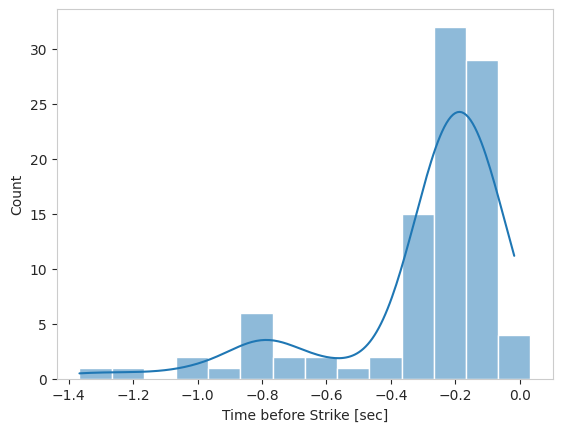

In [ ]:
# with sns.plotting_context("talk"):
fig, ax = plt.subplots(1,1)
sns.histplot(x=list(idx.values()), kde=True, ax=ax, binwidth=0.1)
ax.tick_params(bottom=True, left=True)
ax.set_xlabel('Time before Strike [sec]')
fig.savefig(f'../notebooks/arena_figures/jump_time_before_strikes.pdf', dpi=250, bbox_inches="tight")

# Figure 5 - Head Movements

In [3]:
def calc_exit_hole(af):
    bug_x = af.bug_x.dropna()
    if len(bug_x) == 0:
        return 'unknown'
    return 'right' if np.sign(bug_x.iloc[10] - bug_x.iloc[0]) == 1 else 'left'

def calc_angle_between_lines(a1, b1, a2, b2):
    return np.arccos((a1*a2 + b1*b2) / (np.sqrt(a1**2 + b1**2) * np.sqrt(a2**2 + b2**2)))

def calc_gaze_deviation_angle(ang, bug_y, bug_x, x, y):
    m_exp = (y - bug_y) / (x - bug_x)
    if ang == np.pi/2:
        x_obs = x
        dev_ang = np.math.degrees(calc_angle_between_lines(1, 0, m_exp, -1))
    else:
        m_obs = np.tan(np.pi-ang)
        n_obs = y - m_obs*x
        x_obs = (bug_y - n_obs)/m_obs
        a = distance.euclidean((bug_x, bug_y), (x, y))
        b = distance.euclidean((x_obs, bug_y), (x, y))
        c = np.abs(x_obs - bug_x)
        dev_ang = np.arccos((a**2 + b**2 - c**2) / (2*a*b))
        if ang > np.pi:
            dev_ang = np.pi - dev_ang
        dev_ang = np.math.degrees(dev_ang)

    sgn = np.sign(x_obs - bug_x) if ang < np.pi else -np.sign(x_obs - bug_x)
    return sgn * dev_ang, x_obs

def get_arena(animal_id):
    return 'msi-regev' if animal_id in ['PV80', 'PV42', 'PV85'] else 'reptilearn4'

def add_dev_angle_to_dataframe(af, animal_id):
    dev_angs, x_obss = [], []
    bug_y = SCREEN_Y_POS[get_arena(animal_id)]
    for j, row in af.iterrows():
        if np.isnan(row.bug_x_cm) or np.isnan(row.nose_x) or any(row[f'{bp}_prob'] < 0.8 for bp in ['nose', 'right_ear', 'left_ear']):
            dev_ang, x_obs = np.nan, np.nan
        else:
            dev_ang, x_obs = calc_gaze_deviation_angle(row.angle, bug_y, row.bug_x_cm, row.nose_x, row.nose_y)
        dev_angs.append(dev_ang)
        x_obss.append(x_obs)
    af['dev_angle'] = dev_angs
    af['x_obs'] = x_obss
    return af

def calc_strike_frame(pose_df, orig_strike_frame, delta=20):
    y = pose_df.loc[orig_strike_frame-delta:orig_strike_frame+1, 'nose_y']
    peaks_idx, _ = find_peaks(-y.values, height=-2, distance=10)
    if len(peaks_idx) == 0:
        return orig_strike_frame
    min_peak_id = y[y.index[peaks_idx]].idxmin()
    return min_peak_id

    # for strike_time in strikes_times:
    #     orig_strike_frame = (pose_df.datetime - strike_time).dt.total_seconds().abs().idxmin()
    #     strike_id = pose_df.loc[orig_strike_frame, 'strike_id']
    #     y = pose_df.loc[orig_strike_frame-delta:orig_strike_frame+delta+1, 'nose_y']
    #     peaks_idx, _ = find_peaks(-y.values, height=0, distance=10)
    #     max_peak_id = y[y.index[peaks_idx]].idxmin()
    #     plt.plot([orig_strike_frame, max_peak_id], [y[orig_strike_frame], y[max_peak_id]], '-o', color='tab:orange')

    # plt.scatter(orig_strike_frame, y[orig_strike_frame], color='tab:cyan')
    # plt.scatter(y.index[peaks_idx], y[y.index[peaks_idx]], color='tab:orange')
    # plt.scatter(max_peak_id, y[max_peak_id], color='tab:red')
    # plt.title(f'Strike {strike_id}')
    # plt.show()

def get_pose_df(blk, animal_id):
    dlc = DLCArenaPose('front', orm=orm)
    pose_df = []
    for vid in blk.videos:
        try:
            pdf_ = dlc.load(video_db_id=vid.id)
            pose_df.append(pdf_)
        except Exception:
            pass
    if not pose_df:
        return
    pose_df = pd.concat(pose_df)
    pose_df.columns = ['_'.join(c) if c[1] else c[0] for c in pose_df.columns]
    if 'bug_x_cm' not in pose_df.columns:
        return
    # fix for bug_x
    arena = get_arena(animal_id)
    pose_df['bug_x_cm'] = (pose_df['bug_x'] * SCREEN_PIX_CM[arena]) + SCREEN_START_X[arena]
        
    pose_df['datetime'] = pd.to_datetime(pose_df['time'], unit='s')
    pose_df = add_dev_angle_to_dataframe(pose_df, animal_id)
    return pose_df

def angles_summary(animal_ids, movement_types=None, is_cache=True, is_trial_with_strikes=False):
    cache_path = Path(f'{FIGURE_PATH}/assets/angles_summary_{animal_ids}_{movement_types}_only_strikes_{is_trial_with_strikes}.pkl')
    if is_cache and cache_path.exists():
        with cache_path.open('rb') as f:
            d = pickle.load(f)
            pose_dict, strk_df, tr_df = d['pose_dict'], d['strikes_df'], d['trials_df']
    else:
        with orm.session() as s:
            filters = [
                Experiment.arena.in_(['reptilearn4', 'msi-regev']),
                Experiment.animal_id.in_(animal_ids),
                Experiment.animal_id.startswith('PV'),
                Experiment.start_time > '2023-04-18'
            ]
            if movement_types is not None:
                filters.append(Block.movement_type.in_(movement_types))
            orm_res = s.query(Block, Experiment).join(Experiment, Experiment.id == Block.experiment_id).filter(*filters).all()
            pose_dict, strk_df, trials_valid, tr_df = {}, [], {}, []
            for blk, exp in tqdm(orm_res):
                animal_id = exp.animal_id
                pose_df = get_pose_df(blk, animal_id)
                if pose_df is None:
                    continue
                bug_trajs = []
                for tr in blk.trials:
                    if is_trial_with_strikes and len(tr.strikes) < 1:
                        continue

                    if tr.bug_trajectory:
                        bug_trajs = pd.DataFrame(tr.bug_trajectory)
                        bug_trajs = bug_trajs.rename(columns={'x': 'bug_x', 'y': 'bug_y'})
                        bug_trajs['datetime'] = pd.to_datetime(bug_trajs['time']).dt.tz_localize(None)
                        bug_trajs = bug_trajs.sort_values(by='datetime')
                        exit_hole = calc_exit_hole(bug_trajs)

                        start_time = bug_trajs.iloc[0].datetime - timedelta(seconds=1)
                        end_time = bug_trajs.iloc[-1].datetime + timedelta(seconds=1)
                        trial_pose_df = pose_df[(pose_df.datetime > start_time) & (pose_df.datetime <= end_time)].copy()
                        if len(trial_pose_df) == 0:
                            continue
                        trial_pose_df['strike_id'] = np.nan
                        trials_valid[int(tr.id)] = [(trial_pose_df.datetime-trial_pose_df.datetime.iloc[0]).dt.total_seconds(), trial_pose_df.nose_y]
                        
                        trial_strikes_cache = []
                        tr_df.append({'animal_id': exp.animal_id,'movement_type': blk.movement_type, 
                                      'exit_hole': exit_hole, 'trial_id': int(tr.id), 'bug_speed': blk.bug_speed})
                        for strk in tr.strikes:
                            orig_strike_frame = (trial_pose_df.datetime - strk.time).dt.total_seconds().abs().idxmin()
                            strike_frame = calc_strike_frame(trial_pose_df, orig_strike_frame, delta=20)
                            if strike_frame in trial_strikes_cache:
                                continue
                            trial_strikes_cache.append(strike_frame)

                            trial_pose_df.loc[strike_frame, 'strike_id'] = strk.id
                            trials_valid[int(tr.id)].append((orig_strike_frame, strike_frame, strk.id))
                            strk_df.append({'animal_id': exp.animal_id, 'movement_type': blk.movement_type, 
                                            'bug_type': strk.bug_type, 'bug_size': strk.bug_size, 'strike_id': strk.id, 'trial_id': strk.trial_id,
                                            'is_hit': strk.is_hit, 'bug_speed': strk.calc_speed, 'exit_hole': exit_hole,
                                            'strike_x': strk.x, 'strike_y': strk.y, 
                                            'nose_x': trial_pose_df.loc[strike_frame, 'nose_x'], 'nose_y': trial_pose_df.loc[strike_frame, 'nose_y'],
                                            'orig_nose_x': trial_pose_df.loc[orig_strike_frame, 'nose_x'], 'orig_nose_y': trial_pose_df.loc[orig_strike_frame, 'nose_y']})

                        d_ = pose_dict.setdefault(animal_id, {})
                        d_[tr.id] = trial_pose_df
            strk_df = pd.DataFrame(strk_df).set_index('strike_id')
            tr_df = pd.DataFrame(tr_df).set_index('trial_id')

            # cols = 5
            # rows = int(np.ceil(len(trials_valid)/cols))
            # fig, axes = plt.subplots(rows, cols, figsize=(25, rows*3))
            # axes = axes.flatten()
            # colors = ['tab:orange', 'tab:blue', 'tab:green', 'tab:red', 'tab:purple', 'tab:cyan']
            # for i, trial_id in enumerate(sorted(list(trials_valid.keys()))):
            #     l = trials_valid[trial_id]
            #     t, y = l[:2]
            #     axes[i].plot(t, y, color='k')
            #     for j, (orig_strk_id, strk_id, db_strike_id) in enumerate(l[2:]):
            #         axes[i].scatter(t[orig_strk_id], y[orig_strk_id], color=colors[j], marker='v')
            #         axes[i].scatter(t[strk_id], y[strk_id], color=colors[j], marker='o', label=f'{db_strike_id} {(t[orig_strk_id]-t[strk_id])*1000:.0f}ms')
            #     axes[i].set_ylim([-5, 10])
            #     axes[i].legend()
            #     axes[i].set_title(f'Trial {trial_id}')  
            # fig.tight_layout()

            with cache_path.open('wb') as f:
                pickle.dump({'pose_dict': pose_dict, 'strikes_df': strk_df, 'trials_df': tr_df}, f)
    return pose_dict, strk_df, tr_df


# all_angles_animals = ['PV91', 'PV163', 'PV80', 'PV42', 'PV85', 'PV99', 'PV95', 'PV52']
# all_angles_animals = ['PV91', 'PV163', 'PV99', 'PV95', 'PV52', 'PV97']
all_angles_animals = ['PV91', 'PV163', 'PV99', 'PV95', 'PV80', 'PV42', 'PV85']
chosen_animals = ['PV91', 'PV163', 'PV99', 'PV95']
ocf, strikes_df, trials_df = angles_summary(all_angles_animals, ['random_low_horizontal', 'low_horizontal', 'circle'], is_cache=True, is_trial_with_strikes=False)

In [4]:
FIGURE6_PATH = '../notebooks/arena_figures/figure6'
ANGLES_TIMES = {'trials': [-1, 3], 'strikes': [-3, 0.5]}

def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"


def load_strikes_or_trials(animal_id, trial_id=None, strike_id=None, times=None):
    assert bool(trial_id) ^ bool(strike_id)
    if strike_id:
        trial_id = strikes_df.loc[strike_id, 'trial_id']

    af = ocf[animal_id][trial_id].copy()
    first_x_id = af.bug_x_cm.dropna().index[0] if not strike_id else af.query(f'strike_id=={strike_id}').index[0]
    arena = 'msi-regev' if animal_id in ['PV80', 'PV42', 'PV85'] else 'reptilearn4'
    bug_y = SCREEN_Y_POS[arena]
    af['total_sec'] = (af.datetime - af.datetime.iloc[0]).dt.total_seconds()
    af['total_sec'] = af.total_sec - af.loc[first_x_id, 'total_sec']
    if times is None:
      start, end = ANGLES_TIMES['trials'] if not strike_id else ANGLES_TIMES['strikes']
    else:
      start, end = times
    af = af.query(f'{start}<=total_sec<={end}').reset_index(drop=False)
    af = af.rename(columns={'index': 'frame_id'})
    t_ = af.total_sec.values
    return af, t_, bug_y, arena


def get_video_path(af):
    block_id = int(af.block_id.iloc[0])
    with orm.session() as s:
        blk = s.query(Block).filter_by(id=block_id).first()
        video_path = None
        for vid in blk.videos:
            if vid.cam_name == 'front':
                video_path = vid.path
                break
        if video_path is None:
            raise ValueError(f'Could not find video for block {block_id}')
    video_path = video_path.replace('/data/Pogona_Pursuit/output/experiments', '/media/sil2/Data/regev/experiments/reptilearn4')
    return video_path


def plot_frame_with_dev(frames_df, cols=6):
    video_path = get_video_path(frames_df)
    rows = int(np.ceil(len(frames_df)/cols))
    fig, axes = plt.subplots(rows, cols, figsize=(25, rows*3))
    axes = axes.flatten()

    cap = cv2.VideoCapture(video_path)
    for j in range(len(axes)):
        if j < len(frames_df):
            row = frames_df.iloc[j]
            cap.set(cv2.CAP_PROP_POS_FRAMES, int(row.frame_id))
            ret, frame = cap.read()
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            text_color = (255, 0, 0) if not np.isnan(row.strike_id) else (0, 0, 255)
            put_text(f'Time={row.total_sec:.1f}sec', frame, 10, 100, font_scale=2, thickness=8, color=text_color)
            put_text(f'Angle={np.rad2deg(row.angle):.0f}', frame, 10, 180, font_scale=2, thickness=8, color=text_color)
            put_text(f'Dev.Angle={row.dev_ang:.0f}', frame, 10, 260, font_scale=2, thickness=8, color=text_color)
            put_text(f'BugX={row.bug_x_cm:.2f}', frame, 10, 340, font_scale=2, thickness=8, color=text_color)
            put_text(f'NoseY={row.nose_y-SCREEN_Y_POS["reptilearn4"]:.2f}', frame, 10, 420, font_scale=2, thickness=8, color=text_color)
            for bp in ['nose', 'right_ear', 'left_ear']:
                cv2.circle(frame, (int(row[f'{bp}_cam_x']), int(row[f'{bp}_cam_y'])), 10, (0, 255, 0), -1)
            axes[j].imshow(frame)
        axes[j].axis('off')

    cap.release()


def plot_traj_with_bug(animal_id, trial_id=None, strike_id=None, axes=None, fig=None, triangles_step=10, filename=None, is_plot_frames=True,
                       frames_step=10, times=None):
    af, t_, bug_y, arena = load_strikes_or_trials(animal_id, trial_id, strike_id, times=times)
    if axes is None:
        fig, axes = plt.subplots(1, 2, figsize=(12, 3))

    arrow_len = 0.5
    cmap = cm.get_cmap('jet')
    z = np.linspace(0, 1, len(t_))

    dev_angles, head_angles, bug_trajs = [], [], []
    frames_data = []
    for i, row in af.iterrows():
        if not strike_id and any(row[f'{bp}_prob'] < 0.8 for bp in ['nose', 'right_ear', 'left_ear']):
            continue
        bug_y = SCREEN_Y_POS[arena]
        x, y, bug_x, ang = row.nose_x, row.nose_y, row.bug_x_cm, row.angle
        if np.isnan(x) or np.isnan(y) or np.isnan(bug_x):
            continue
        color = cmap(z[i])
        dev_ang, x_obs = calc_gaze_deviation_angle(ang, bug_y, bug_x, x, y)
        dev_angles.append((row.total_sec, dev_ang))
        head_angles.append((row.total_sec, np.rad2deg(row.angle)))
        bug_trajs.append((row.total_sec, row.bug_y, row.bug_x_cm))
        axes[1].scatter(row.total_sec, dev_ang, color=color)
        # if not np.isnan(row.strike_id):
          # for k in range(1, 4):
          # axes[k].axvline(row.total_sec, color='r', linestyle='--')
        if is_plot_frames and not (i % frames_step):
            row['dev_ang'] = dev_ang
            row['color'] = color
            frames_data.append(row)

        if i % triangles_step:
            continue

        axes[0].scatter(x, y, marker='o', s=20, color=color)
        axes[0].scatter(bug_x, bug_y, color=color, marker='o', s=20)
        if not np.isnan(bug_x):
            if ang < np.pi:
                axes[0].plot([x, x_obs], [y, bug_y], '--', color=color)
            axes[0].plot([x, bug_x], [y, bug_y], color=color)
        axes[0].annotate('', (x-arrow_len*np.cos(np.pi - ang), y-arrow_len*np.sin(np.pi - ang)), (x, y), 
                    arrowprops=dict(width=0.3, headwidth=10, headlength=14, shrink=.1, 
                                    facecolor=color, edgecolor='k'))

    if is_plot_frames:
        frames_data = pd.DataFrame(frames_data)
        plot_frame_with_dev(frames_data)

    exit_hole = calc_exit_hole(af)
    for i, l in enumerate([dev_angles]):  # , head_angles, bug_trajs
      t = np.array([x[0] for x in l])
      a = np.array([x[1] for x in l])
      axes[i+1].plot(t, a, color='k', zorder=-1)
    
    axes[0].set_xlim([0, 70])
    title = f'Trial={trial_id}' if not strike_id else f'Strike={strike_id}'
    axes[0].set_title(f'{animal_id}, {title}, exit: {exit_hole}\n{af.datetime.iloc[0].strftime("%d/%m/%Y %H:%M:%S")}')
    axes[0].invert_yaxis()
    axes[0].add_patch(Rectangle((7, bug_y-1), 43, 2, linewidth=1, edgecolor='none', facecolor='grey', alpha=0.4))
    axes[0].axis('off')
    
    axes[1].axhline(0, color='k', linestyle='--', alpha=0.5)
    axes[1].axvline(0, color='k', linestyle='--', alpha=0.5)
    axes[1].set_ylim([-180, 180])
    
    # axes[2].set_ylim([0, 180])
    # axes[2].set_ylabel('Head Angle [deg]')
    # axes[3].set_ylabel('Bug_y [pixels]')
    
    for i in range(2):  
      axes[i].set_ylabel('Θ [deg]')
      axes[i].set_xlabel('Post-bug-onset time [s]' if not strike_id else 'Pre-strike time [s]')
      axes[i].margins(x=0)
      # xticks = np.arange(ANGLES_TIMES['trials'][0], ANGLES_TIMES['trials'][1]+1, 1)
      # axes[i].set_xticks(xticks)

    if fig is not None:
        fig.colorbar(cm.ScalarMappable(norm=plt.Normalize(t_[0], t_[-1]), cmap=cmap), ax=axes[1], label='Time around strike [sec]')
        fig.tight_layout()
        if filename:
            fig.savefig(f'{FIGURE6_PATH}/{filename}.pdf', dpi=200, bbox_inches='tight')
 

# plot_traj_with_bug('PV91', trial_id=10789, frames_step=4, triangles_step=25, filename='example_left_exit')
# plot_traj_with_bug('PV91', trial_id=15273, triangles_step=25, is_plot_frames=False, times=(0, 20))

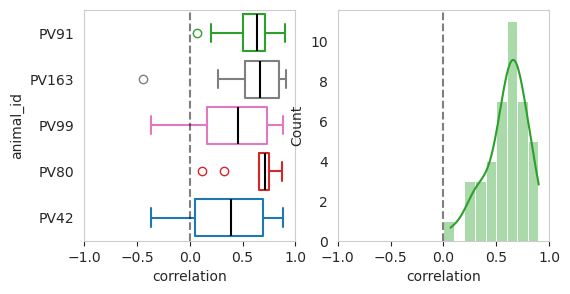

In [39]:
from matplotlib.ticker import FixedLocator, MaxNLocator


def calc_head_bug_corr(animal_id, trial_id, times=None, is_plot=True, th=0.8, min_duration=10, only_strikes=False):
    af_orig, t_, bug_y, arena = load_strikes_or_trials(animal_id, trial_id, None, times=times)
    af = af_orig.query(f'nose_prob>{th} and right_ear_prob>{th} and left_ear_prob>{th} and bug_x_cm==bug_x_cm').copy()
    af['angle'] = af.angle.map(np.rad2deg)
    if len(af) == 0 or af.total_sec.iloc[-1] < min_duration or (only_strikes and af_orig.query('strike_id==strike_id').empty):
        return None, None
    
    c = np.corrcoef(af.angle, -af.bug_x_cm)[0, 1]
    # strikes = af_orig.strike_id.dropna().values
    # is_hit_last_strike = strikes_df.loc[strikes[-1]].is_hit
    # n_strikes = len(strikes) - 1 if is_hit_last_strike else len(strikes)
    # n_strikes = af_orig.query('strike_id==strike_id').total_sec.iloc[0]
    if not is_plot:
      return c, af.time.iloc[0]
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    ax2 = axes[0].twinx()
    ax2.plot(af.total_sec, -af.bug_x_cm, color='tab:orange')
    # ax2.invert_yaxis()
    ax2.set_ylabel('Bug_x [cm]', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    
    axes[0].plot(af.total_sec, af.angle, label='Head angle')
    axes[0].set_ylabel('Head Angle [deg]')
    axes[0].set_title(f'{animal_id}, Trial={trial_id}, corr={c:.2f}')
    
    axes[1].plot(af.total_sec, af.bug_y, label='Bug-Y')
    axes[1].set_ylabel('Bug-Y [pix]')
    
    for i, row in af_orig.query('strike_id==strike_id').iterrows():
      axes[0].axvline(row.total_sec, color='r', linestyle='--')
      axes[1].axvline(row.total_sec, color='r', linestyle='--')
    fig.tight_layout()

def corr_plot(axes=None):
    example_animal = 'PV91'
    animals = ['PV91', 'PV163', 'PV99', 'PV80', 'PV42']
    if axes is None:
      fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    
    cf = []
    for i, animal_id in enumerate(animals):
      if animal_id in ['PV80', 'PV42']:
        xf = trials_df.query(f'movement_type=="circle" and animal_id=="PV99"').sample(70, random_state=int(animal_id[2:])-1).sort_index()
        animal_id_ = 'PV99'
      else:
        xf = trials_df.query(f'movement_type=="circle" and animal_id=="{animal_id}"').sort_index()
        animal_id_ = animal_id
          
      corrs = []
      for trial_id in xf.index:
        try:
          c, t0 = calc_head_bug_corr(animal_id_, trial_id, times=(0, 20), is_plot=False, min_duration=10, only_strikes=True)
          if c is not None:
              corrs.append({'trial_id': trial_id, 'correlation': c, 'time': t0, 'animal_id': animal_id})
        except Exception as e:
          continue
      if not corrs:
        continue
      corrs = pd.DataFrame(corrs).sort_values(by='time')
      cf.append(corrs)
      if animal_id == example_animal:
        sns.histplot(data=corrs, x='correlation', ax=axes[1], bins=np.arange(-1, 1, 0.1), kde=True, alpha=0.4, color=COLORS[example_animal])
        axes[1].axvline(0, color='k', linestyle='--', alpha=0.5)
    cf = pd.concat(cf)
    sns.boxplot(data=cf,  x='correlation', y='animal_id', hue='animal_id', legend=False, ax=axes[0], fill=False, medianprops={"color": "k"}, palette=COLORS)
    axes[0].axvline(0, color='k', linestyle='--', alpha=0.5)
    axes[0].set_xlim([-1, 1])
    axes[1].set_xlim([-1, 1])
    
corr_plot()

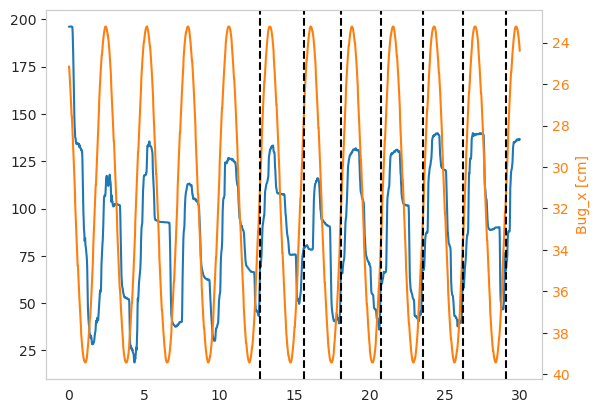

In [27]:
def plot_head_bug_sync(animal_id, trial_id, times=None, ax=None, th=0.8):
    af_orig, t_, bug_y, arena = load_strikes_or_trials(animal_id, trial_id, None, times=times)
    af = af_orig.query(f'nose_prob>{th} and right_ear_prob>{th} and left_ear_prob>{th} and bug_x_cm==bug_x_cm').copy()
    af['angle'] = af.angle.map(np.rad2deg)
    if ax is None:
      ax = plt.subplot()
    ax.plot(af.total_sec, af.angle, label='Head angle')
    ax2 = ax.twinx()
    ax2.plot(af.total_sec, af.bug_x_cm, color='tab:orange', zorder=-1)
    ax2.invert_yaxis()
    ax2.set_ylabel('Bug_x [cm]', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    for i, row in af_orig.query('strike_id==strike_id').iterrows():
      ax2.axvline(row.total_sec, color='k', linestyle='--')
    
plot_head_bug_sync('PV91', 15273, times=(0, 30))

In [7]:
def _calc_avg_dev_angle(animal_id, trial_id, strike_id, t, is_dev_speed, is_abs, min_y=None, max_ang=None):
    af, t_, _, _ = load_strikes_or_trials(animal_id, trial_id, strike_id)
    # if not strike_id and not af.query('strike_id==strike_id').empty:
    #     return
    af.loc[af.angle>np.pi, 'dev_angle'] = np.nan
    if min_y is not None:
        af.loc[af.nose_y<min_y, 'dev_angle'] = np.nan
    if max_ang is not None:
        af.loc[af.angle>max_ang, 'angle'] = np.nan
    dev_angs = af.dev_angle.values
    # dev_angs = savgol_filter(dev_angs, 5, 1, mode='nearest')
    dev_angs_speed = savgol_filter(dev_angs, 5, 1, deriv=1, delta=1/60, mode='nearest')

    if is_dev_speed:
        dev_angs = dev_angs_speed
    if is_abs:
        dev_angs = np.abs(dev_angs)
    dx_ = np.interp(t, t_, dev_angs)
    return dx_


def calc_avg_dx(animal_id, ax=None, is_strike=False, is_dev_speed=False, is_abs=False, is_plot_all=False,
                exit_hole=None, line_color='tab:blue', label='', bug_speed=None, min_y=None, max_ang=None):
    res = []
    t = np.arange(*ANGLES_TIMES['trials'], 0.01) if not is_strike else np.arange(*ANGLES_TIMES['strikes'], 0.01)
    for trial_id in ocf[animal_id].keys():
        trial_exit_hole = calc_exit_hole(ocf[animal_id][trial_id])
        if exit_hole and trial_exit_hole != exit_hole:
            continue
        
        a = None
        if is_strike:
            for strike_id in ocf[animal_id][trial_id].strike_id.dropna().unique():
                if bug_speed:
                    v = strikes_df.loc[strike_id, 'bug_speed']
                    if np.isnan(v) or round(v) != bug_speed:
                        continue
                a = _calc_avg_dev_angle(animal_id, None, strike_id, t, is_dev_speed, is_abs, min_y=min_y, max_ang=max_ang)
                res.append(a)
        else:
            a = _calc_avg_dev_angle(animal_id, trial_id, None, t, is_dev_speed, is_abs, min_y=min_y, max_ang=max_ang)
            res.append(a)
        if is_plot_all and a is not None:
            ax.plot(t, a, color=line_color, alpha=0.2)
    
    res = np.vstack(res)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        avg_res = np.nanmean(res, axis=0)
    if ax is not None:
        ax.plot(t, avg_res, color=line_color if not is_plot_all else 'k', label=label, linewidth=2)
        ax.axhline(0, color='k', linestyle='--', alpha=0.5)
        ax.axvline(0, color='k', linestyle='--', alpha=0.5)
    return avg_res, t, res


# _, axes_ = plt.subplots(1, 2, figsize=(10, 3))
# animal_id = 'PV91'
# kwargs = dict(is_strike=False, is_dev_speed=False, max_ang=np.pi, min_y=None, is_plot_all=True)
# calc_avg_dx(animal_id, exit_hole='left', ax=axes_[0], line_color='tab:red', **kwargs)
# calc_avg_dx(animal_id, exit_hole='right', ax=axes_[1], line_color='tab:green', **kwargs);

In [9]:
def plot_trial_bug_traj(animal_id, trial_id, times=None, ax=None):
    no_bug_y = 0
    movement_type = trials_df.loc[trial_id,'movement_type']
    af_orig, t_, bug_y, arena = load_strikes_or_trials(animal_id, trial_id, None, times=times)
    if movement_type == 'circle':
      af_orig['total_sec'] = af_orig['total_sec'] / 3
      af_orig.loc[af_orig['bug_x_cm'] > 40, 'bug_x_cm'] = np.nan
    start, end = af_orig.bug_x_cm.dropna().index[0], af_orig.bug_x_cm.dropna().index[-1]
    with sns.plotting_context("talk"):
      if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(3, 3))
      ax.plot(af_orig.total_sec, af_orig.bug_x_cm)
      ax.plot([0, 0], [no_bug_y, af_orig.loc[start, 'bug_x_cm']], color='k', linestyle='--')
      ax.plot([af_orig.loc[end, 'total_sec'], af_orig.loc[end, 'total_sec']], [no_bug_y, af_orig.loc[end, 'bug_x_cm']], color='k', linestyle='--')
      ax.plot([-3, 0], [no_bug_y, no_bug_y], color='r')
      ax.plot([af_orig.loc[end, 'total_sec'], af_orig.loc[end, 'total_sec']+3], [no_bug_y, no_bug_y], color='r')
      ax.add_patch(Rectangle((af_orig.loc[start, 'total_sec'], 10), 
                             af_orig.loc[end, 'total_sec']-af_orig.loc[start, 'total_sec'], 40,
                             linewidth=1, edgecolor='none', facecolor='mistyrose', alpha=0.6))
      ax.set_xlabel('Time [s]')
      ax.set_xticks([0, 5, 10, 15])
      ax.set_yticks([0, 10, 50])
      ax.set_yticklabels(['No Prey', '10', '50'])

# plot_trial_bug_traj('PV91', 15273, times=(-2, 50))
# plot_trial_bug_traj('PV91', 10993, times=(-2, 50))

In [205]:
ANIMALS

['PV91', 'PV163', 'PV80', 'PV42', 'PV99']

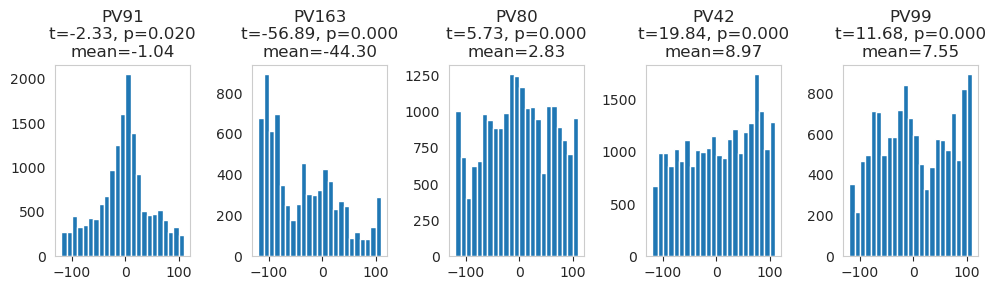

In [213]:
res = {}
fig, axes = plt.subplots(1, len(ANIMALS), figsize=(10, 3)) 
for i, animal_id in enumerate(ANIMALS):
  res[animal_id] = {}
  for trial_id in ocf[animal_id].keys():
      try:
          af, t_, bug_y, arena = load_strikes_or_trials(animal_id, trial_id=trial_id)
          exit_hole = calc_exit_hole(af)
          af = af.query(f'0 <= total_sec <= 1 and angle < {np.pi}').copy()
          res[animal_id].setdefault(exit_hole, []).extend(af.dev_angle.dropna().values.tolist())
      except Exception as e:
          continue
  
  x = res[animal_id]['right']+res[animal_id]['left']
  axes[i].hist(x, bins=np.arange(-120, 120, 10))
  t_statistic, p_value = ttest_1samp(x, 0)
  axes[i].set_title(f'{animal_id}\nt={t_statistic:.2f}, p={p_value:.3f}\nmean={np.mean(x):.2f}')
  
fig.tight_layout()

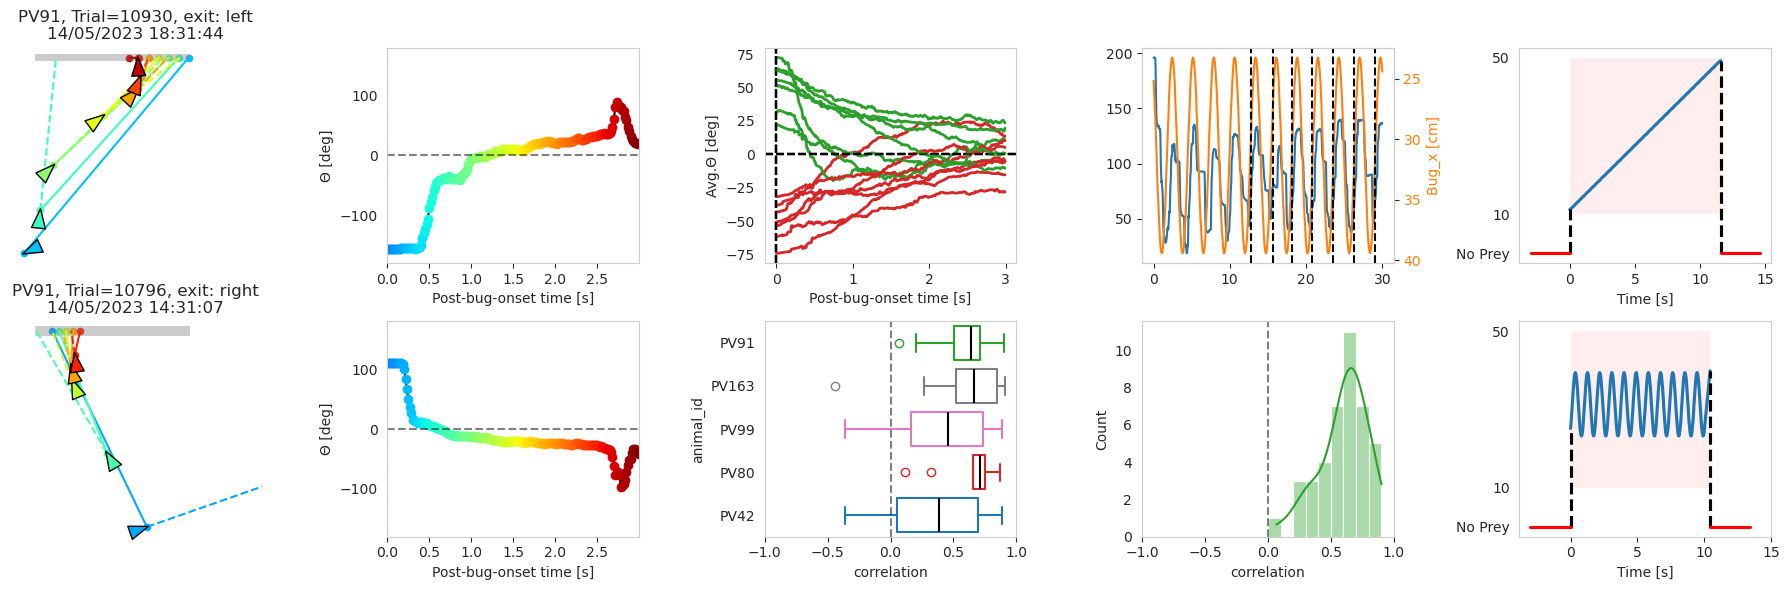

In [40]:
# Figure 6

def plot_figure6():
    fig, axes = plt.subplots(2, 5, figsize=(18, 6))
    plot_traj_with_bug('PV91', trial_id=10930, triangles_step=25, is_plot_frames=False, axes=axes[0, :2])  # dwh: 
    plot_traj_with_bug('PV91', trial_id=10796, triangles_step=35, is_plot_frames=False, axes=axes[1, :2])  # dwh: 
 
    kwargs = dict(is_strike=False, is_dev_speed=False, max_ang=np.pi, min_y=None, is_plot_all=False)
    for animal_id in all_angles_animals:
        calc_avg_dx(animal_id, exit_hole='left', ax=axes[0, 2], line_color='tab:red', **kwargs)
        calc_avg_dx(animal_id, exit_hole='right', ax=axes[0, 2], line_color='tab:green', **kwargs)
    axes[0, 2].set_ylabel('Avg.Θ [deg]')
    axes[0, 2].set_xlabel('Post-bug-onset time [s]')
    corr_plot(axes[1, 2:4])
    plot_head_bug_sync('PV91', 15273, times=(0, 30), ax=axes[0, 3])
    plot_trial_bug_traj('PV91', 10993, times=(-2, 50), ax=axes[0, 4])
    plot_trial_bug_traj('PV91', 15273, times=(-2, 50), ax=axes[1, 4])
    
    fig.tight_layout()
    fig.savefig(f'{FIGURE_PATH}/Figure5/Fig5.pdf', dpi=250)

plot_figure6()

In [ ]:
animal_id = 'PV80'
n = 100
xf = trials_df.query(f'movement_type=="circle" and animal_id=="{animal_id}"').sample(n).sort_index()
cols = 6
rows = int(np.ceil(n/cols))
fig, axes = plt.subplots(rows, cols, figsize=(20, 3*rows))
axes = axes.flatten()
for i, trial_id in enumerate(xf.index):
  try:
    plot_head_bug_sync(animal_id, trial_id, times=(0, 20), ax=axes[i])
  except Exception as exc:
    continue
  axes[i].set_title(trial_id)
fig.tight_layout()

In [ ]:
n = 30
animal_id = 'PV163'
xf = trials_df.query(f'movement_type=="circle" and animal_id=="{animal_id}"').sample(n).sort_index()
fig, axes = plt.subplots(len(xf), 4, figsize=(15, len(xf)*3))
for i, trial_id in enumerate(xf.index):
  plot_traj_with_bug(animal_id, trial_id=trial_id, triangles_step=25, is_plot_frames=False, axes=axes[i, :], times=(0, 20))
fig.tight_layout()

In [ ]:
plot_traj_with_bug('PV91', trial_id=10930, triangles_step=25, is_plot_frames=False, axes=axes[0, :2])

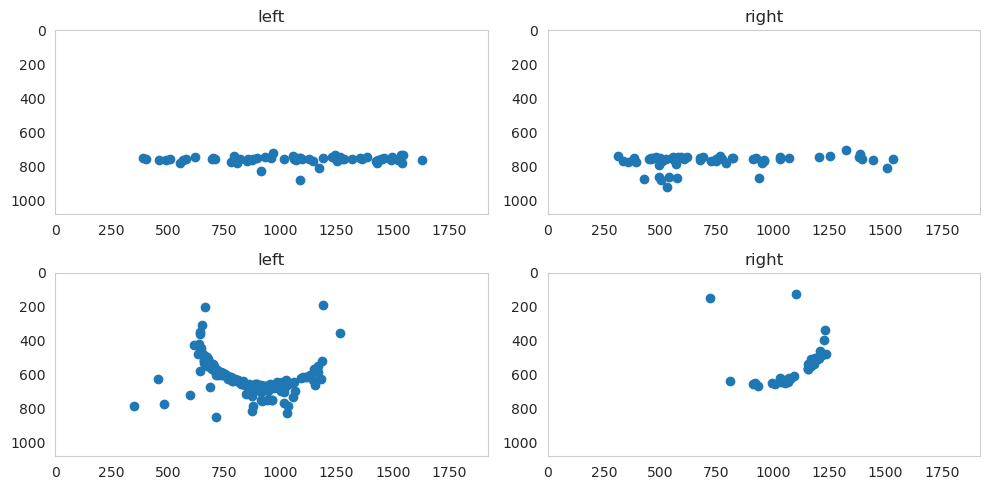

In [36]:
animal_id = 'PV91'
fig, axes = plt.subplots(2, 2, figsize=(10, 5))
for i, mt in enumerate(['random_low_horizontal', 'circle']):
  for j, side in enumerate(['left', 'right']):
      x = strikes_df.query(f'exit_hole=="{side}" and animal_id=="{animal_id}" and movement_type=="{mt}"')[['strike_x', 'strike_y']]
      axes[i, j].scatter(x.strike_x, x.strike_y)
      axes[i, j].set_xlim([0, 1920])
      axes[i, j].set_ylim([0, 1080])
      axes[i, j].invert_yaxis()
      axes[i, j].set_title(side)
fig.tight_layout()

Chosen start_x = 5.71 cm


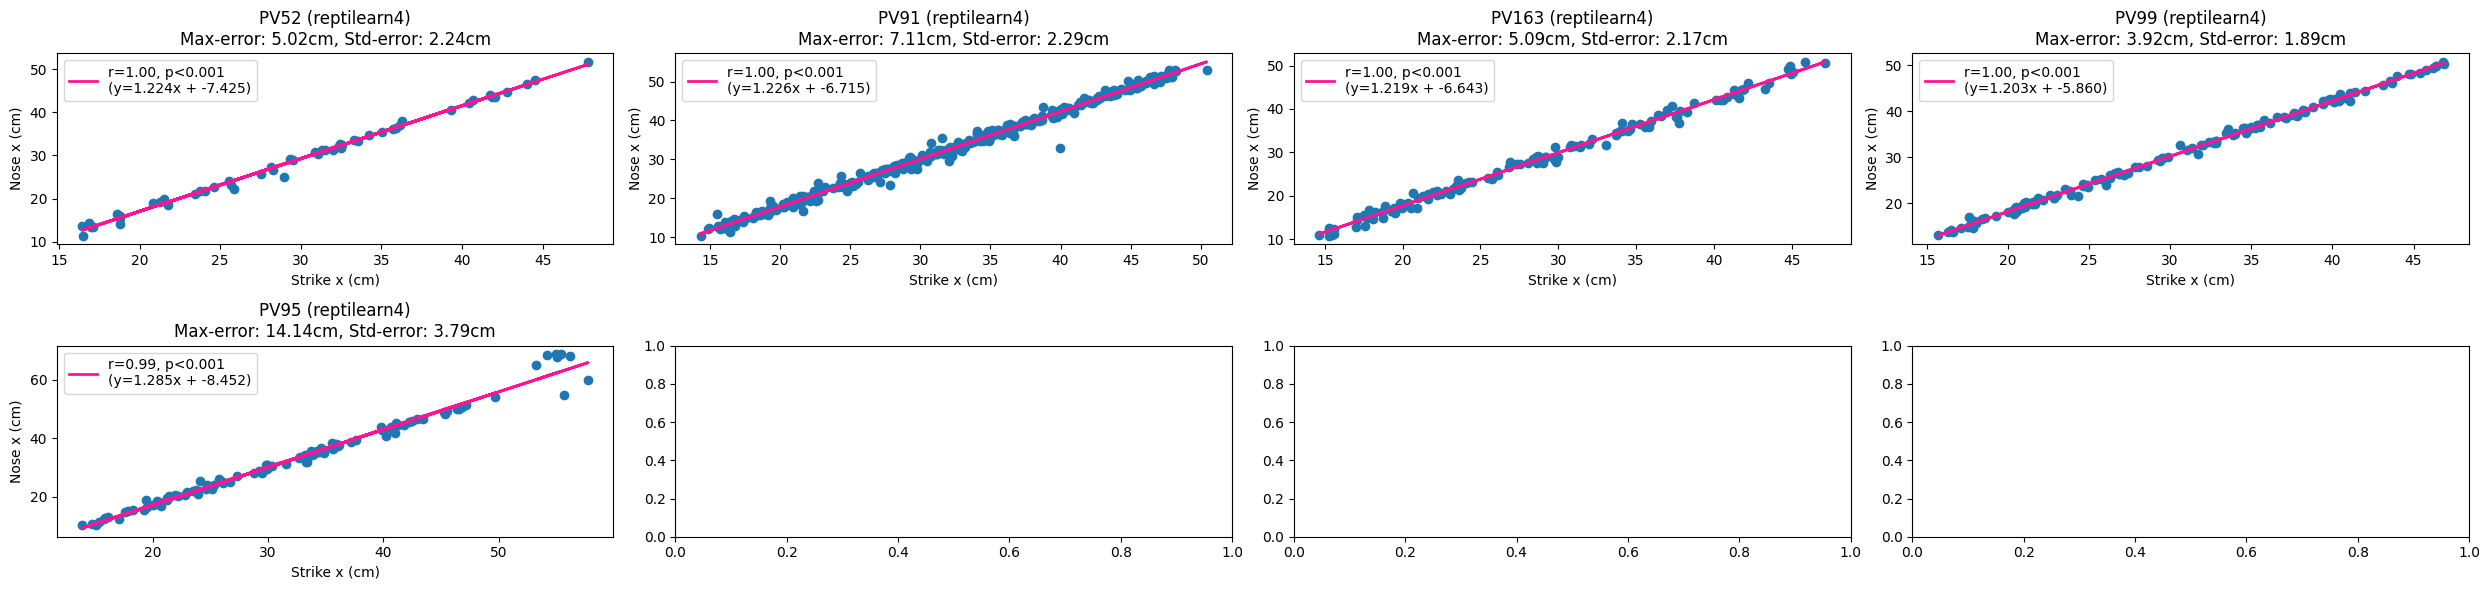

In [24]:
SCREEN_PIX_CM = {'reptilearn4': 52.704/1920, 'msi-regev': 34.3/1920}

def calc_screen_pose_alignment(animal_id, screen_start_x=0, ax=None):
    arena = get_arena(animal_id)
    xf = strikes_df.query(f'animal_id == "{animal_id}"')
    strike_x = SCREEN_PIX_CM[arena]*xf['strike_x'].values + screen_start_x
    nose_x = xf['nose_x'].values
    # print(animal_id, xf.index[np.where(np.abs(nose_x - strike_x) > 5)[0]].tolist())
    max_error = np.abs((nose_x - strike_x)).max()
    std_error = np.sqrt(((nose_x - strike_x)**2).sum() / (len(nose_x) - 1))

    if ax is not None:
        ax.scatter(strike_x, nose_x)
        plot_regression(ax, strike_x, nose_x, is_legend_outside=False, is_line_equation=True)
        ax.set_title(f'{animal_id} ({arena})\nMax-error: {max_error:.2f}cm, Std-error: {std_error:.2f}cm')
        ax.set_xlabel('Strike x (cm)')
        ax.set_ylabel('Nose x (cm)')

    return max_error, std_error


def find_optimal_start_x():
    start_x_array = np.arange(3, 7, 0.01)
    errors = []
    for start_x in start_x_array:
        errs_ = []
        for i, animal_id in enumerate(all_angles_animals):
            max_error, std_error = calc_screen_pose_alignment(animal_id, screen_start_x=start_x)
            errs_.append(std_error)
        errors.append(np.mean(errs_))
    
    start_x = start_x_array[np.argmin(errors)]
    print(f'Chosen start_x = {start_x:.2f} cm')
    cols = 4
    rows = int(np.ceil(len(all_angles_animals) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(25, 3*rows))
    axes = axes.flatten()
    for i, animal_id in enumerate(all_angles_animals):
        calc_screen_pose_alignment(animal_id, screen_start_x=start_x, ax=axes[i])
    fig.tight_layout()


find_optimal_start_x()

In [ ]:
def plot_strike(strike_id):
    row = strikes_df.loc[strike_id]
    af, t_, bug_y, arena = load_strikes_or_trials(row.animal_id, trial_id=row.trial_id)
    strike_time = af.query('strike_id==strike_id').total_sec.iloc[0]
    af_ = af.query(f'{strike_time-1} <= total_sec <= {strike_time+3}').copy()

    strike_screen_x = SCREEN_PIX_CM[arena]*row.strike_x + SCREEN_START_X[arena]

    plt.plot(af_.total_sec.values, af_.nose_y.values, color='tab:blue')
    plt.plot(af_.total_sec.values, af_.nose_x.values, color='tab:orange')
    plt.axvline(strike_time, color='k', linestyle='--')
    plt.axhline(strike_screen_x, color='tab:red', linestyle='--')

    af_ = add_dev_angle_to_dataframe(af_, row.animal_id)
    af_ = af_.rename(columns={'dev_angle': 'dev_ang'})
    plot_frame_with_dev(af_)


plot_strike(3032)

# Ephys Figure

In [2]:
from scipy.io import loadmat
from scipy.signal import resample

PV157_ANALYSIS_DIR = '/media/sil3/Data/Pogona_Vitticeps/PV157/1_Hunter/PV157_Trial7_Hunter5_2024-03-07_14-12-21/analysis_with_pose'
M = loadmat(f'{PV157_ANALYSIS_DIR}/PV157_hunter5_Ch8_firstTrialData.mat')
M = {k: v.ravel() for k, v in M.items() if not k.startswith('__')}
start_frame = M['frame_num'][0]
pose_df = pd.read_parquet(f'{PV157_ANALYSIS_DIR}/front_head_ephys_resnet_101__top_20240307T141316.parquet')
pose_df.columns = ['_'.join(c) if c[1] else c[0] for c in pose_df.columns]
pose_df['ephys_time'] = pose_df.time - pose_df.loc[start_frame, 'time']
frames_ts = pd.read_csv(f'{PV157_ANALYSIS_DIR}/top_20240307T141316.csv', index_col=0, names=['time'], header=0)
M.keys()

dict_keys(['data_high_pass_M', 'data_high_pass_T', 'data_lfp_M', 'data_lfp_T', 'frame_num', 't_end_trial', 't_start_trial', 't_strike'])

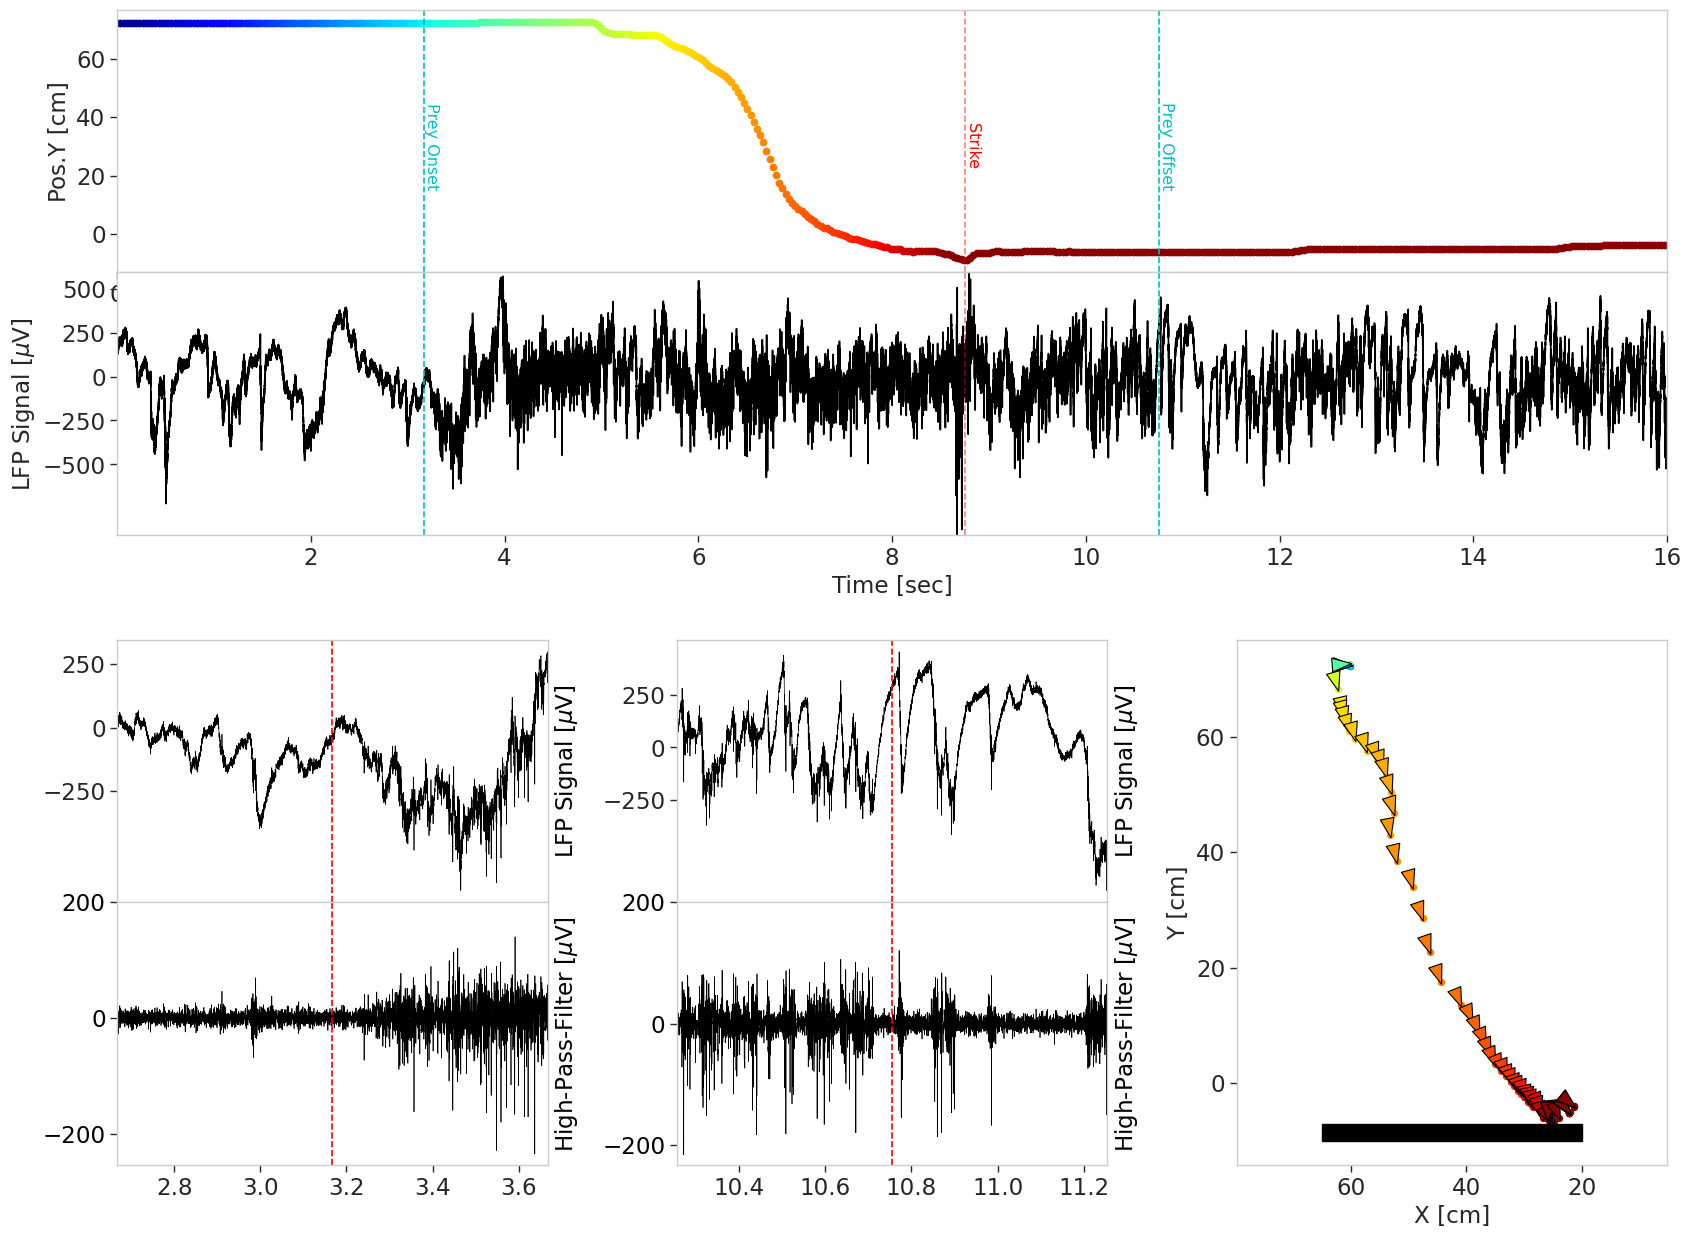

In [174]:
import matplotlib.patches as patches

def plot_ephys_and_y_values(v_lfp, t_lfp, axes, cmap, z, ps_):
    # ax1 = fig.add_axes([0, 0.7, 1, 0.3], xticklabels=[])
    # ax2 = fig.add_axes([0, 0, 1, 0.7])
    for i, row in ps_.reset_index().iterrows():
      axes[0].scatter(row.ephys_time, row.nose_y, color=cmap(z[i] if i < len(z) else 0.99))
    # axes[0].plot(ps_.ephys_time, ps_['nose_y'], color='k')
    axes[1].plot(t_lfp/1000, v_lfp, color='k')
    axes[0].set_ylabel('Pos.Y [cm]')
    axes[1].set_ylabel(r'LFP Signal [$\mu$V]')
    axes[1].set_yticks([-500, -250, 0, 250, 500])
    for ax in axes:
        for c in ['t_start_trial', 't_end_trial']:
            ax.axvline(M[c][0]/1000, color='c', linestyle='--')
        ax.axvline(M['t_strike'][0]/1000, color='r', linestyle='--', alpha=0.5)
    axes[1].set_xlabel('Time [sec]')
    axes[0].text(M['t_start_trial'][0]/1000, 30, 'Prey Onset', rotation=270, va='center', color='c')
    axes[0].text(M['t_end_trial'][0]/1000, 30, 'Prey Offset', rotation=270, va='center', color='c')
    axes[0].text(M['t_strike'][0]/1000, 30, 'Strike', rotation=270, va='center', color='r')
    axes[0].grid(False)
    axes[1].grid(False)
    axes[0].margins(0, None)
    axes[1].margins(0, 0)

def plot_enlarged_signal_example(axes, event_name, t_lfp, v_lfp):
    v_hp, t_hp = M['data_high_pass_M'], M['data_high_pass_T']
    t0 = M[event_name][0]
    idx = np.where((t_hp>t0-500) & (t_hp<t0+500))[0]
    axes[0].plot(t_lfp[idx]/1000, v_lfp[idx], color='k', linewidth=0.5)
    axes[0].set_ylabel(r'LFP Signal [$\mu$V]', color='k')
    axes[0].set_xlabel('Time [sec]')
    # axes[0].set_ylim([-700, 500])
    axes[0].set_yticks([-250, 0, 250])
    axes[0].grid(False)
    axes[0].margins(0, None)
    axes[0].axvline(t0/1000, color='red', linestyle='--')
    axes[0].yaxis.set_label_position("right")
    
    axes[1].plot(t_hp[idx]/1000, v_hp[idx], color='k', linewidth=0.5)
    axes[1].set_ylabel(r'High-Pass-Filter [$\mu$V]', color='k')
    axes[1].tick_params(axis='y', labelcolor='k')
    # axes[1].set_ylim([-300, 300])
    axes[1].set_yticks([-200, 0, 200])
    axes[1].grid(False)
    axes[1].margins(0, None)
    axes[1].axvline(t0/1000, color='red', linestyle='--')
    axes[1].yaxis.set_label_position("right")

def plot_head_triangles(ps_, cmap, z, ax):
    arrow_len = 0.5
    for i, row in ps_.reset_index().iterrows():
        if (i<175 and i % 40) or (175<=i<245 and i % 2) or (i>=245 and i % 10):
          continue
        x, y, ang = row.nose_x, row.nose_y, row.angle
        color = cmap(z[i] if i < len(z) else 0.99)
        ax.scatter(x, y, marker='o', s=20, color=color)
        # ax.text(x, y-5, str(i))
        ax.annotate('', (x-arrow_len*np.cos(np.pi - ang), y-arrow_len*np.sin(np.pi - ang)), (x, y), 
                    arrowprops=dict(width=0.3, headwidth=10, headlength=14, shrink=.1, facecolor=color, edgecolor='k'))
    
    rect = patches.Rectangle((20, -10), 45, 3, linewidth=1, edgecolor='k', facecolor='k')
    ax.add_patch(rect)
    ax.grid(False)
    ax.set_xlabel('X [cm]')
    ax.set_ylabel('Y [cm]')
    ax.invert_xaxis()
    ax.axis('equal')
    # ax.set_ylim([-10, 75])
    # ax.margins(None, 0)
    
def plot_ephys_figure():
    v_lfp, t_lfp = M['data_lfp_M'], M['data_lfp_T']
    # v_lfp, t_lfp = resample(v_lfp, round(len(v_lfp)/50), t=t_lfp)
    
    start_frame = 860
    start_vid_time = frames_ts.loc[start_frame].time
    end_vid_time = start_vid_time + (t_lfp[-1] / 1000)
    end_frame = (frames_ts - end_vid_time).time.abs().idxmin()
    pose_df['ephys_time'] = pose_df.time - pose_df.loc[start_frame, 'time']
    ps_ = pose_df.loc[start_frame:end_frame]
    
    params = {'legend.fontsize': 'x-large',
             'axes.labelsize': 'x-large',
             'axes.titlesize':'x-large',
             'xtick.labelsize':'x-large',
             'ytick.labelsize':'x-large'}
    plt.rcParams.update(params)
    fig = plt.figure(figsize=(20, 15))
    grid = fig.add_gridspec(ncols=1, nrows=2, hspace=0.2)
    axes1 = grid[0].subgridspec(2, 1, hspace=0).subplots()
    grid1 = grid[1].subgridspec(1, 3, wspace=0.3)
    axes2 = grid1[:2].subgridspec(2, 2, hspace=0, wspace=0.3).subplots()
    ax_triangle = grid1[2].subgridspec(1, 1).subplots()
    cmap = cm.get_cmap('jet')
    k = (ps_.reset_index().ephys_time - M['t_strike'][0]/1000).abs().idxmin()
    z = np.linspace(0, 1, k)  # len(ps_)
    
    plot_ephys_and_y_values(v_lfp, t_lfp, axes1, cmap, z, ps_)
    plot_head_triangles(ps_, cmap, z, ax_triangle)
    plot_enlarged_signal_example(axes2[:, 0], 't_start_trial', t_lfp, v_lfp)
    plot_enlarged_signal_example(axes2[:, 1], 't_end_trial', t_lfp, v_lfp)
    
    
    fig.savefig('/media/sil2/Data/regev/Papers/PreyTouch/ephys/pv157_1.pdf', bbox_inches='tight')
    
plot_ephys_figure()

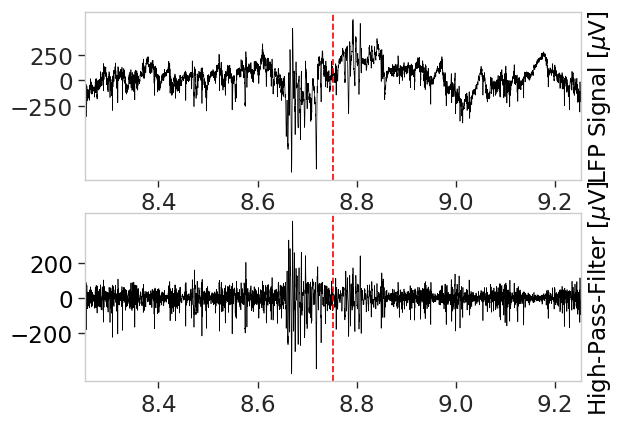

In [175]:
fig, axes_ = plt.subplots(2, 1)
v_lfp, t_lfp = M['data_lfp_M'], M['data_lfp_T']
plot_enlarged_signal_example(axes_, 't_strike', t_lfp, v_lfp)
fig.savefig('/media/sil2/Data/regev/Papers/PreyTouch/ephys/pv157_t_strike.pdf', bbox_inches='tight')

In [176]:
M['t_strike']

array([8751.4])

IndexError: index 53352 is out of bounds for axis 0 with size 6400

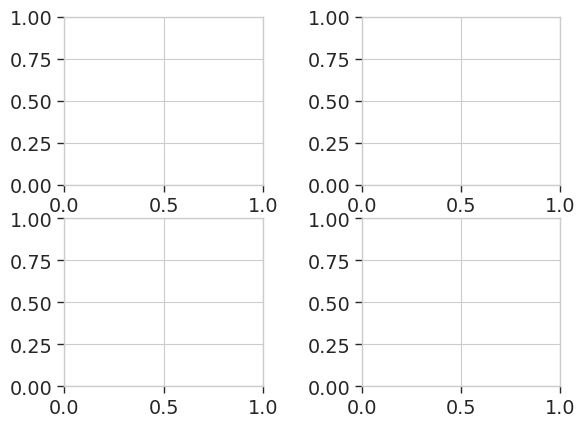

In [107]:
v_hp, t_hp = M['data_high_pass_M'], M['data_high_pass_T']

params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
          "ytick.left": True,
         "ytick.direction": 'out',
         "xtick.bottom": True,
         "xtick.direction": 'out'}
plt.rcParams.update(params)

fig = plt.figure()
grid = fig.add_gridspec(ncols=2, nrows=1, wspace=0.5)
axes = [grid[i].subgridspec(2, 1, hspace=0.2).subplots() for i in range(2)]

for c, axes_ in zip(['t_start_trial', 't_end_trial'], axes):
  ax, ax2 = axes_
  t0 = M[c][0]
  idx = np.where((t_hp>t0-500) & (t_hp<t0+500))[0]
  ax.plot(t_lfp[idx]/1000, v_lfp[idx], color='k', linewidth=0.5)
  ax.set_ylabel(r'LFP Signal [$\mu$V]', color='k')
  ax.set_xlabel('Time [sec]')
  ax.set_ylim([-700, 500])
  ax.set_yticks([-250, 0, 250])
  ax.grid(False)
  ax.margins(0, 0)
  ax.yaxis.set_label_position("right")
  
  ax2.plot(t_hp[idx]/1000, v_hp[idx], color='k', linewidth=0.5)
  ax2.set_ylabel(r'High-Pass-Filter [$\mu$V]', color='k')
  ax2.tick_params(axis='y', labelcolor='k')
  ax2.set_ylim([-300, 300])
  ax2.set_yticks([-200, 0, 200])
  ax2.grid(False)
  ax2.margins(0, 0)
  ax2.yaxis.set_label_position("right")
  
fig.savefig('/media/sil2/Data/regev/Papers/PreyTouch/ephys/pv157_2.pdf', bbox_inches='tight')

In [82]:
start_frame - (end_frame - start_frame)

1815

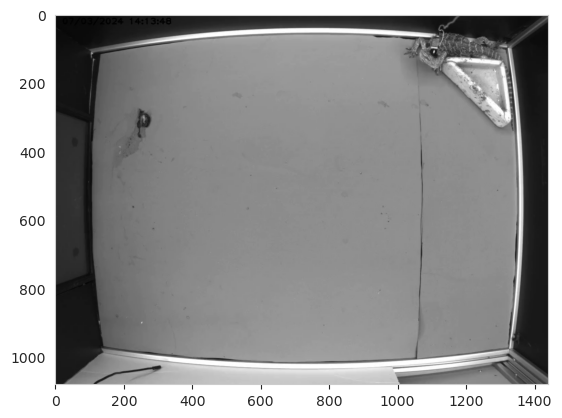

In [87]:
cap = cv2.VideoCapture(f'{PV157_ANALYSIS_DIR}/top_20240307T141316.mp4')
cap.set(cv2.CAP_PROP_POS_FRAMES, 1000)
ret, frame = cap.read()
plt.imshow(frame)
cap.release()

# Latency Figure

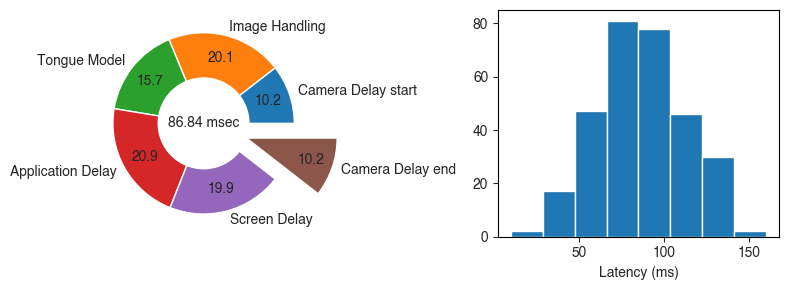

In [7]:
total_latency = 97.04
cam_delay = (10.2, 7)
latencies = {
    'Camera Delay start': cam_delay,
    'Image Handling': (20.1, 7),
    'Tongue Model': (15.7, 12),
    'Application Delay': (20.94, 13.49)
}
latencies['Screen Delay'] = (total_latency - sum([v[0] for v in latencies.values()]) - cam_delay[0], 0)
latencies['Camera Delay end'] = cam_delay
explode = (0, 0, 0, 0, 0, 0.5)
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].pie([l[0] for l in latencies.values()], labels=list(latencies.keys()), autopct=lambda x: '{:.1f}'.format(x*total_latency/100), pctdistance=0.75, explode=explode)
my_circle = plt.Circle((0,0), 0.5, color='white')
axes[0].add_artist(my_circle)
axes[0].text(0, 0, f'{total_latency-cam_delay[0]} msec', horizontalalignment='center', verticalalignment='center')


with open(FIGURE_PATH + 'assets/latency.pkl', 'rb') as f:
    d = pickle.load(f)
    data = d['data'] - cam_delay[0]
    
axes[1].hist(data, bins=8)
axes[1].set_xlabel('Latency (ms)')

fig.tight_layout()
fig.savefig(FIGURE_PATH + 'latency_test.pdf', bbox_inches='tight')

In [8]:
data.std()

27.47793939181526